## Imports

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict

from sklearn.datasets import fetch_openml            # common data set access
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from sklearn.metrics import zero_one_loss
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier       # Used in 2D data problems
from sklearn.linear_model import LogisticRegression  # Used in MNIST data problem
from sklearn.linear_model import LogisticRegressionCV
import torch
import joblib
import random
import time

seed = 1234
np.random.seed(seed) 

from scipy.ndimage import rotate

## Loading and Scaling Data

In [ ]:
# 1. Setup the paths
base_path = "." 
images_folder = os.path.join(base_path, "images")
csv_file = os.path.join(base_path, "legend.csv")

# 2. Read CSV file
df = pd.read_csv(csv_file)

# Lists to store our data
data = []   # This will become X
labels = [] # This will become y

# Define a fixed size for images. For example, MINST is 28*28, here we do 64*64 
IMG_SIZE = 64

print("Loading images... this might take a moment.")

# 3. Loop through the CSV and load images
for index, row in df.iterrows():
    img_name = row['image']
    emotion = row['emotion']

    img_path = os.path.join(images_folder, img_name)

    # Check if file actually exists to avoid errors
    if os.path.exists(img_path):
        # Load image in Grayscale (usually sufficient for emotion detection)
        # If you want color, remove the second argument.
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img_array is not None:
            # Resize the image (Crucial step!) - original shape is 350x350
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            
            # Flatten the image
            # This converts the 2D image (64x64) into a 1D row of numbers (4096,)
            flat_array = new_array.flatten()
            
            # Add the flat data entry 
            data.append(flat_array)
            # Add label
            labels.append(emotion)

# 4. Convert to Numpy Arrays (X and y)
X = np.array(data)
y = np.array(labels)

print("Data loaded successfully!")
print(f"Features (X) shape: {X.shape}") # Should be (Number of images, 4096)
print(f"Labels (y) shape: {y.shape}")    # Should be (Number of images,)

Loading images... this might take a moment.
Data loaded successfully!
Features (X) shape: (13690, 4096)
Labels (y) shape: (13690,)
Data loaded successfully!
Features (X) shape: (13690, 4096)
Labels (y) shape: (13690,)


## Data Exploration and Visualization

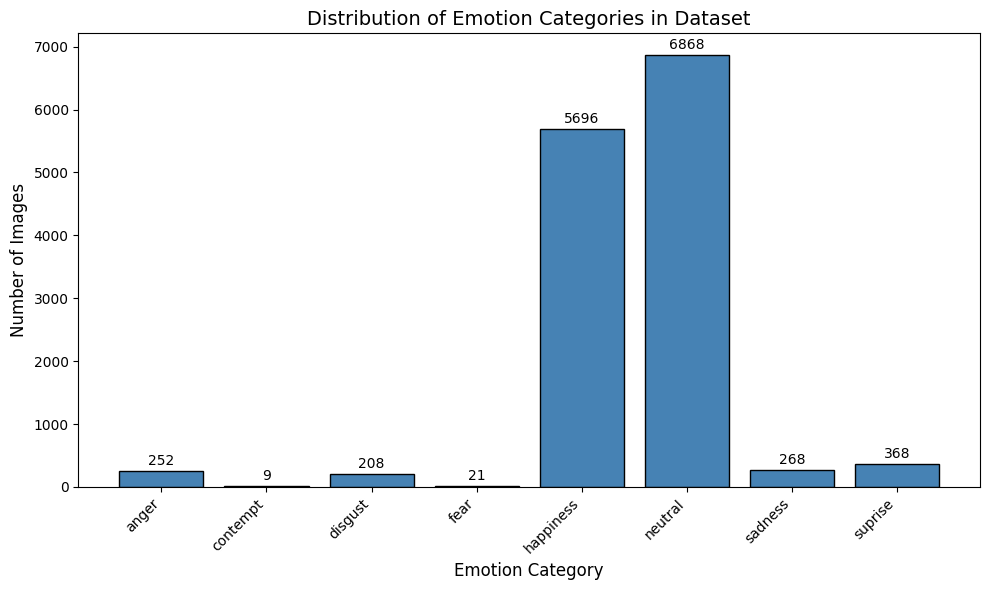


=== Dataset Summary ===
Total number of images: 13690
Number of emotion categories: 8

Class distribution:
  anger: 252 (1.8%)
  contempt: 9 (0.1%)
  disgust: 208 (1.5%)
  fear: 21 (0.2%)
  happiness: 5696 (41.6%)
  neutral: 6868 (50.2%)
  sadness: 268 (2.0%)
  suprise: 368 (2.7%)


In [ ]:
# 1. Class Distribution - Bar Chart
emotion_counts = pd.Series(y).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(emotion_counts.index, emotion_counts.values, color='steelblue', edgecolor='black')
ax.set_xlabel('Emotion Category', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Distribution of Emotion Categories in Dataset', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add count labels on bars
for bar, count in zip(bars, emotion_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Dataset Summary ===")
print(f"Total number of images: {len(y)}")
print(f"Number of emotion categories: {len(emotion_counts)}")
print(f"\nClass distribution:")
for emotion, count in emotion_counts.items():
    percentage = count / len(y) * 100
    print(f"  {emotion}: {count} ({percentage:.1f}%)")

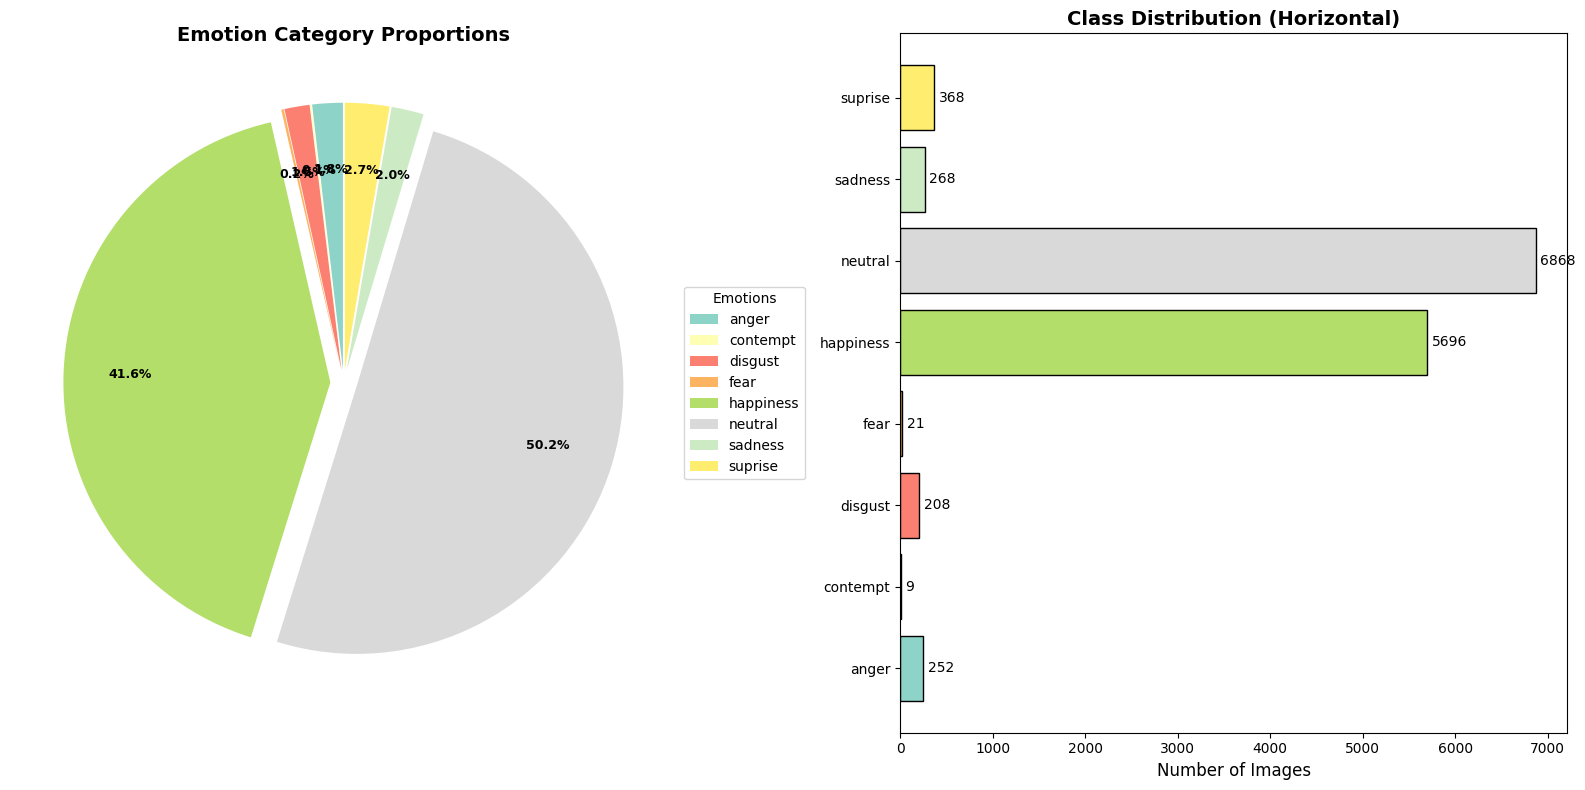


=== Class Imbalance Analysis ===
Largest class: neutral with 6868 samples
Smallest class: contempt with 9 samples
Imbalance ratio (max/min): 763.11x


In [ ]:
# 2. Class Imbalance Visualization - Pie Chart
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Pie chart - improved readability
colors = plt.cm.Set3(np.linspace(0, 1, len(emotion_counts)))

# Use legend instead of labels directly on pie for cleaner look
wedges, texts, autotexts = axes[0].pie(emotion_counts.values, 
                                        autopct='%1.1f%%', 
                                        colors=colors, 
                                        startangle=90,
                                        explode=[0.05] * len(emotion_counts),
                                        pctdistance=0.75)

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_fontsize(9)
    autotext.set_fontweight('bold')

# Add legend outside the pie chart for clarity
axes[0].legend(wedges, emotion_counts.index, title="Emotions", 
               loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10)
axes[0].set_title('Emotion Category Proportions', fontsize=14, fontweight='bold')

# Horizontal bar chart for better comparison
y_pos = np.arange(len(emotion_counts))
axes[1].barh(y_pos, emotion_counts.values, color=colors, edgecolor='black')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(emotion_counts.index)
axes[1].set_xlabel('Number of Images', fontsize=12)
axes[1].set_title('Class Distribution (Horizontal)', fontsize=14, fontweight='bold')

# Add count labels - renamed loop variable to avoid shadowing 'y'
for idx, (count, pos) in enumerate(zip(emotion_counts.values, y_pos)):
    axes[1].text(count + 50, pos, str(count), va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Calculate imbalance ratio
max_class = emotion_counts.max()
min_class = emotion_counts.min()
print(f"\n=== Class Imbalance Analysis ===")
print(f"Largest class: {emotion_counts.idxmax()} with {max_class} samples")
print(f"Smallest class: {emotion_counts.idxmin()} with {min_class} samples")
print(f"Imbalance ratio (max/min): {max_class/min_class:.2f}x")

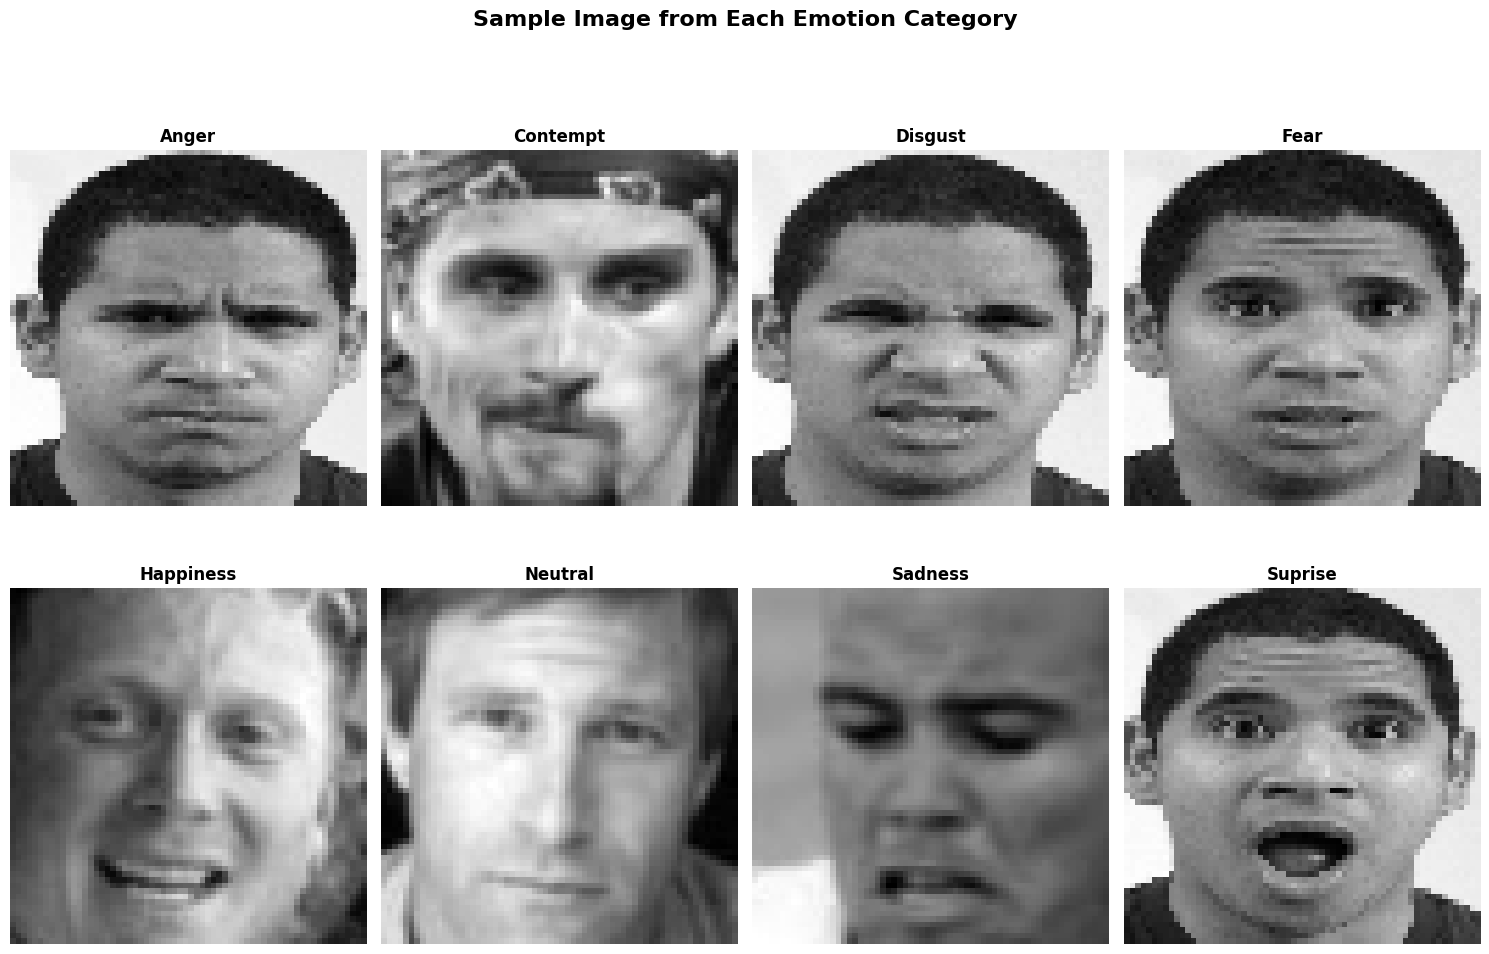

In [ ]:
# 3. Sample Image from Each Emotion Category
unique_emotions = np.unique(y)
n_emotions = len(unique_emotions)

# Create a grid to display one sample from each emotion
fig, axes = plt.subplots(2, (n_emotions + 1) // 2, figsize=(15, 10))
axes = axes.flatten()

for i, emotion in enumerate(unique_emotions):
    # Get first image of this emotion
    idx = np.where(y == emotion)[0][0]
    axes[i].imshow(X[idx].reshape(64, 64), cmap='gray')
    axes[i].set_title(f'{emotion.capitalize()}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

# Hide any extra subplots
for j in range(len(unique_emotions), len(axes)):
    axes[j].axis('off')

plt.suptitle('Sample Image from Each Emotion Category', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

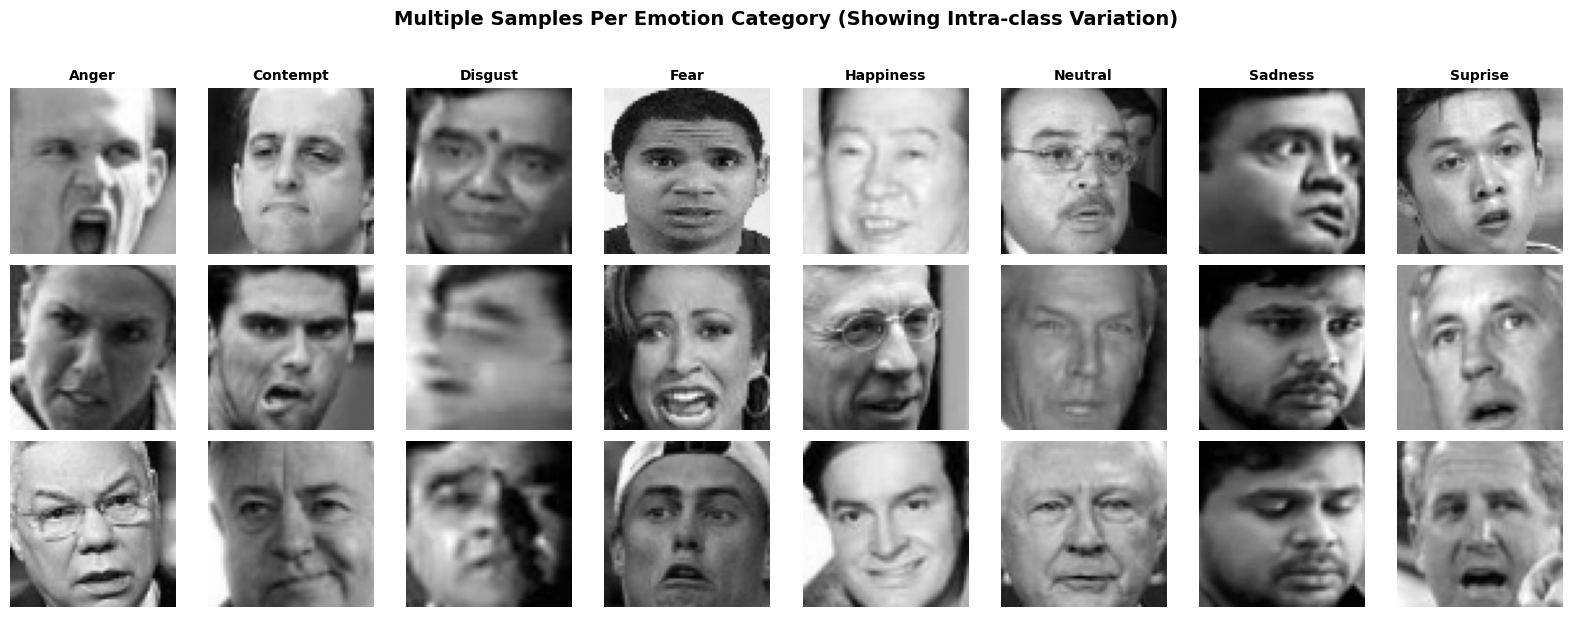

In [ ]:
# 4. Multiple Samples Per Emotion (3x8 grid showing variety within each class)
n_samples_per_class = 3

fig, axes = plt.subplots(n_samples_per_class, n_emotions, figsize=(16, 6))

for j, emotion in enumerate(unique_emotions):
    # Get indices for this emotion
    emotion_indices = np.where(y == emotion)[0]
    # Randomly select samples (or take first few if not enough)
    n_available = min(n_samples_per_class, len(emotion_indices))
    sample_indices = np.random.choice(emotion_indices, n_available, replace=False)
    
    for i in range(n_samples_per_class):
        if i < n_available:
            axes[i, j].imshow(X[sample_indices[i]].reshape(64, 64), cmap='gray')
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(emotion.capitalize(), fontsize=10, fontweight='bold')

plt.suptitle('Multiple Samples Per Emotion Category (Showing Intra-class Variation)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

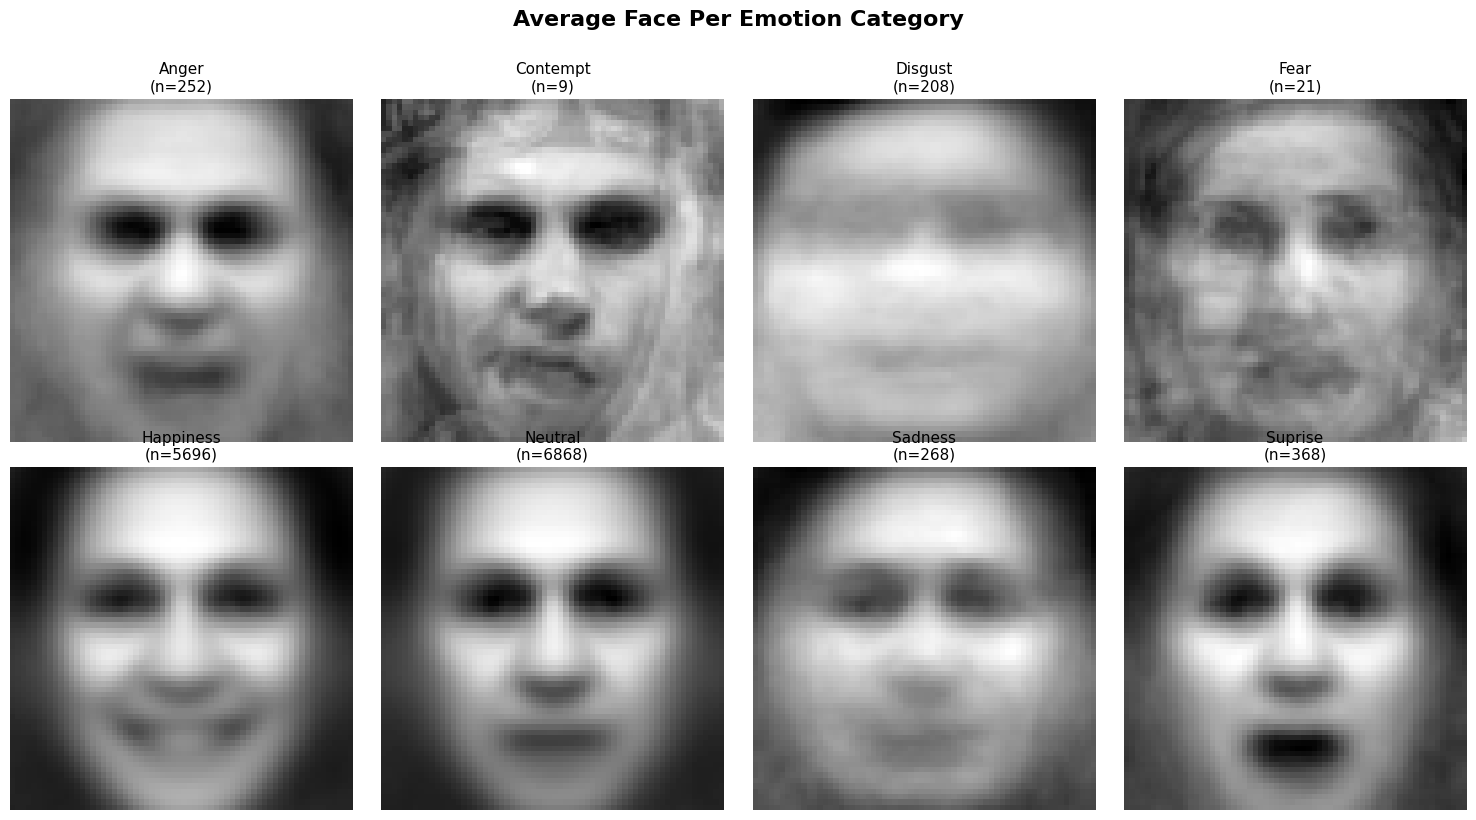

In [ ]:
# 5. Average Face per Emotion Category
fig, axes = plt.subplots(2, (n_emotions + 1) // 2, figsize=(15, 8))
axes = axes.flatten()

for i, emotion in enumerate(unique_emotions):
    # Calculate mean face for this emotion
    emotion_images = X[y == emotion]
    mean_face = emotion_images.mean(axis=0).reshape(64, 64)
    
    axes[i].imshow(mean_face, cmap='gray')
    axes[i].set_title(f'{emotion.capitalize()}\n(n={len(emotion_images)})', fontsize=11)
    axes[i].axis('off')

# Hide any extra subplots
for j in range(len(unique_emotions), len(axes)):
    axes[j].axis('off')

plt.suptitle('Average Face Per Emotion Category', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Logistic Regression Model

### Hyperparameter Search via Cross-Validation
We'll search over several hyperparameters:
- **C**: Regularization strength (inverse). Smaller = stronger regularization
- **penalty**: Type of regularization ('l1' for Lasso, 'l2' for Ridge)
- **solver**: Optimization algorithm (must be compatible with penalty choice)

We use 5-fold cross-validation on the training data, then evaluate the best models on the validation set.

In [ ]:
from sklearn.model_selection import cross_val_score
import time

# Define hyperparameter grid
# C values: range from strong regularization (0.001) to weak regularization (100)
# Added more granularity around the 0.1 region which showed promise
C_values = [0.001, 0.005, 0.01, 0.05, 0.1]

# Penalty and solver combinations (must be compatible)
# AVOIDING 'saga' - it's extremely slow on high-dimensional data (4096 features)
# - 'l2' works with: 'lbfgs', 'newton-cg', 'sag'
# - 'l1' works with: 'liblinear' (but liblinear uses one-vs-rest, not multinomial)
penalty_solver_combos = [
    ('l2', 'lbfgs'),      # L2 with LBFGS - fast, default for multiclass
    ('l2', 'newton-cg'),  # L2 with Newton-CG - good for multiclass
    ('l1', 'liblinear'),  # L1 regularization (sparse) - liblinear is fast
]

# Store results
cv_results = []

print("=" * 70)
print("LOGISTIC REGRESSION HYPERPARAMETER SEARCH")
print("=" * 70)
print(f"Training set size: {X_tr.shape[0]} samples")
print(f"Feature dimension: {X_tr.shape[1]} features")
print(f"Using 5-fold cross-validation on training data")
print(f"Testing {len(C_values)} C values × {len(penalty_solver_combos)} penalty/solver combos")
print(f"Total configurations: {len(C_values) * len(penalty_solver_combos)}")
print("=" * 70)
print("NOTE: Skipping 'saga' solver - too slow for high-dimensional data")
print("=" * 70)

start_time_total = time.time()

for penalty, solver in penalty_solver_combos:
    print(f"\n--- Penalty: {penalty}, Solver: {solver} ---")
    
    for C in C_values:
        start_time = time.time()
        
        # Create model
        model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            class_weight='balanced',
            max_iter=2000,
            random_state=seed,
            n_jobs=-1 if solver != 'liblinear' else 1  # liblinear doesn't support n_jobs
        )
        
        # 5-fold cross-validation on training data
        cv_scores = cross_val_score(model, X_tr, y_tr, cv=5, scoring='accuracy', n_jobs=-1)
        
        # Calculate metrics
        cv_mean_acc = cv_scores.mean()
        cv_std_acc = cv_scores.std()
        cv_mean_error = 1 - cv_mean_acc
        
        elapsed = time.time() - start_time
        
        # Store results
        cv_results.append({
            'C': C,
            'penalty': penalty,
            'solver': solver,
            'cv_mean_accuracy': cv_mean_acc,
            'cv_std_accuracy': cv_std_acc,
            'cv_mean_error': cv_mean_error,
            'time_seconds': elapsed
        })
        
        print(f"  C={C:<6} | CV Accuracy: {cv_mean_acc:.4f} ± {cv_std_acc:.4f} | "
              f"Error: {cv_mean_error:.4f} | Time: {elapsed:.1f}s")

total_time = time.time() - start_time_total
print(f"\n{'=' * 70}")
print(f"Total search time: {total_time/60:.1f} minutes")
print("=" * 70)

LOGISTIC REGRESSION HYPERPARAMETER SEARCH
Training set size: 9583 samples
Feature dimension: 4096 features
Using 5-fold cross-validation on training data
Testing 5 C values × 3 penalty/solver combos
Total configurations: 15
NOTE: Skipping 'saga' solver - too slow for high-dimensional data

--- Penalty: l2, Solver: lbfgs ---
  C=0.001  | CV Accuracy: 0.6264 ± 0.0082 | Error: 0.3736 | Time: 28.6s
  C=0.001  | CV Accuracy: 0.6264 ± 0.0082 | Error: 0.3736 | Time: 28.6s
  C=0.005  | CV Accuracy: 0.6605 ± 0.0031 | Error: 0.3395 | Time: 35.0s
  C=0.005  | CV Accuracy: 0.6605 ± 0.0031 | Error: 0.3395 | Time: 35.0s
  C=0.01   | CV Accuracy: 0.6715 ± 0.0062 | Error: 0.3285 | Time: 33.4s
  C=0.01   | CV Accuracy: 0.6715 ± 0.0062 | Error: 0.3285 | Time: 33.4s
  C=0.05   | CV Accuracy: 0.6843 ± 0.0036 | Error: 0.3157 | Time: 36.9s
  C=0.05   | CV Accuracy: 0.6843 ± 0.0036 | Error: 0.3157 | Time: 36.9s
  C=0.1    | CV Accuracy: 0.6837 ± 0.0051 | Error: 0.3163 | Time: 25.4s

--- Penalty: l2, Solver: 

/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.001  | CV Accuracy: 0.5016 ± 0.0004 | Error: 0.4984 | Time: 6.4s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.005  | CV Accuracy: 0.6278 ± 0.0111 | Error: 0.3722 | Time: 8.9s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.01   | CV Accuracy: 0.6922 ± 0.0057 | Error: 0.3078 | Time: 10.3s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.05   | CV Accuracy: 0.7192 ± 0.0044 | Error: 0.2808 | Time: 16.7s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.1    | CV Accuracy: 0.7202 ± 0.0042 | Error: 0.2798 | Time: 29.1s

Total search time: 6.2 minutes


In [ ]:
# Convert results to DataFrame and display
cv_results_df = pd.DataFrame(cv_results)

# Sort by CV accuracy (descending)
cv_results_df = cv_results_df.sort_values('cv_mean_accuracy', ascending=False).reset_index(drop=True)

print("=" * 70)
print("CROSS-VALIDATION RESULTS (sorted by CV accuracy)")
print("=" * 70)
print(cv_results_df.to_string(index=True))

# Get top 5 configurations
print("\n" + "=" * 70)
print("TOP 5 CONFIGURATIONS")
print("=" * 70)
for i, row in cv_results_df.head(5).iterrows():
    print(f"{i+1}. C={row['C']}, penalty={row['penalty']}, solver={row['solver']}")
    print(f"   CV Accuracy: {row['cv_mean_accuracy']:.4f} ± {row['cv_std_accuracy']:.4f}")
    print(f"   CV Error Rate: {row['cv_mean_error']:.4f}")
    print()

CROSS-VALIDATION RESULTS (sorted by CV accuracy)
        C penalty     solver  cv_mean_accuracy  cv_std_accuracy  cv_mean_error  time_seconds
0   0.100      l1  liblinear          0.720233         0.004203       0.279767     29.080520
1   0.050      l1  liblinear          0.719190         0.004401       0.280810     16.682086
2   0.010      l1  liblinear          0.692163         0.005710       0.307837     10.315719
3   0.050      l2      lbfgs          0.684338         0.003595       0.315662     36.861381
4   0.100      l2  newton-cg          0.684233         0.003684       0.315767     27.126326
5   0.100      l2      lbfgs          0.683712         0.005116       0.316288     25.412100
6   0.050      l2  newton-cg          0.683503         0.002657       0.316497     27.583153
7   0.010      l2  newton-cg          0.671711         0.005770       0.328289     31.429792
8   0.010      l2      lbfgs          0.671502         0.006224       0.328498     33.352403
9   0.005      l2  ne

### Cross-Validation Accuracy Across Iterations
We sweep over increasing `max_iter` values for every `(penalty, solver, C)` combination to understand convergence behavior before locking in the final hyperparameters.

In [ ]:
max_iter_grid = [200, 400, 800, 1200, 2000]
cv_iter_records = []

print("=" * 70)
print("CROSS-VALIDATION VS. ITERATIONS")
print("=" * 70)
print(f"Iter grid: {max_iter_grid}")
print(f"{len(penalty_solver_combos)} solver combos × {len(C_values)} Cs × {len(max_iter_grid)} max_iter points")
print("This may take a few minutes...\n")

for penalty, solver in penalty_solver_combos:
    print(f"=== Penalty: {penalty}, Solver: {solver} ===")
    for C in C_values:
        print(f"  C = {C}")
        for max_iter in max_iter_grid:
            model = LogisticRegression(
                C=C,
                penalty=penalty,
                solver=solver,
                class_weight='balanced',
                max_iter=max_iter,
                random_state=seed,
                n_jobs=-1 if solver != 'liblinear' else 1
            )
            start_time = time.time()
            cv_scores = cross_val_score(model, X_tr, y_tr, cv=5, scoring='accuracy', n_jobs=-1)
            elapsed = time.time() - start_time
            cv_iter_records.append({
                'penalty': penalty,
                'solver': solver,
                'C': C,
                'max_iter': max_iter,
                'cv_mean_accuracy': cv_scores.mean(),
                'cv_std_accuracy': cv_scores.std(),
                'time_seconds': elapsed
            })
            print(
                f"    max_iter={max_iter:<4} | CV Acc: {cv_scores.mean():.4f} ± {cv_scores.std():.4f} | Time: {elapsed:.1f}s"
            )
    print()

cv_iter_df = pd.DataFrame(cv_iter_records)
print("Completed iteration sweep.")
display(cv_iter_df.head())

CROSS-VALIDATION VS. ITERATIONS
Iter grid: [200, 400, 800, 1200, 2000]
3 solver combos × 5 Cs × 5 max_iter points
This may take a few minutes...

=== Penalty: l2, Solver: lbfgs ===
  C = 0.001


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-le

    max_iter=200  | CV Acc: 0.6227 ± 0.0082 | Time: 9.5s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 400 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=400).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 400 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=400).
You might also want to scale the data as shown in:
    https://scikit-le

    max_iter=400  | CV Acc: 0.6256 ± 0.0081 | Time: 15.5s
    max_iter=800  | CV Acc: 0.6264 ± 0.0082 | Time: 27.3s
    max_iter=1200 | CV Acc: 0.6264 ± 0.0082 | Time: 25.6s
    max_iter=2000 | CV Acc: 0.6264 ± 0.0082 | Time: 27.5s
  C = 0.005


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-le

    max_iter=200  | CV Acc: 0.6638 ± 0.0050 | Time: 10.4s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 400 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=400).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 400 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=400).
You might also want to scale the data as shown in:
    https://scikit-le

    max_iter=400  | CV Acc: 0.6614 ± 0.0037 | Time: 15.4s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 400 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=400).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 800 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=800).
You might also want to scale the data as shown in:
    https://scikit-le

    max_iter=800  | CV Acc: 0.6604 ± 0.0030 | Time: 29.3s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 800 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=800).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    max_iter=1200 | CV Acc: 0.6605 ± 0.0031 | Time: 34.4s
    max_iter=2000 | CV Acc: 0.6605 ± 0.0031 | Time: 32.8s
  C = 0.01


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-le

    max_iter=200  | CV Acc: 0.6738 ± 0.0063 | Time: 8.7s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 400 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=400).
You might also want to scale the data as shown in:
    https://scikit-le

    max_iter=400  | CV Acc: 0.6717 ± 0.0064 | Time: 17.2s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 800 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=800).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 800 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=800).
You might also want to scale the data as shown in:
    https://scikit-le

    max_iter=800  | CV Acc: 0.6714 ± 0.0061 | Time: 28.6s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 800 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=800).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    max_iter=1200 | CV Acc: 0.6715 ± 0.0062 | Time: 34.8s
    max_iter=2000 | CV Acc: 0.6715 ± 0.0062 | Time: 32.8s
  C = 0.05


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-le

    max_iter=200  | CV Acc: 0.6821 ± 0.0063 | Time: 8.3s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 400 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=400).
You might also want to scale the data as shown in:
    https://scikit-le

    max_iter=400  | CV Acc: 0.6830 ± 0.0032 | Time: 15.8s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 400 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=400).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 800 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=800).
You might also want to scale the data as shown in:
    https://scikit-le

    max_iter=800  | CV Acc: 0.6835 ± 0.0030 | Time: 30.7s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 800 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=800).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    max_iter=1200 | CV Acc: 0.6843 ± 0.0036 | Time: 34.5s
    max_iter=2000 | CV Acc: 0.6843 ± 0.0036 | Time: 35.1s
  C = 0.1


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-le

    max_iter=200  | CV Acc: 0.6833 ± 0.0048 | Time: 8.0s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 400 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=400).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 400 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=400).
You might also want to scale the data as shown in:
    https://scikit-le

    max_iter=400  | CV Acc: 0.6836 ± 0.0032 | Time: 15.6s
    max_iter=800  | CV Acc: 0.6837 ± 0.0051 | Time: 25.3s
    max_iter=1200 | CV Acc: 0.6837 ± 0.0051 | Time: 26.3s
    max_iter=2000 | CV Acc: 0.6837 ± 0.0051 | Time: 29.8s

=== Penalty: l2, Solver: newton-cg ===
  C = 0.001
    max_iter=200  | CV Acc: 0.6264 ± 0.0085 | Time: 26.0s
    max_iter=400  | CV Acc: 0.6264 ± 0.0085 | Time: 24.5s
    max_iter=800  | CV Acc: 0.6264 ± 0.0085 | Time: 24.7s
    max_iter=1200 | CV Acc: 0.6264 ± 0.0085 | Time: 24.9s
    max_iter=2000 | CV Acc: 0.6264 ± 0.0085 | Time: 22.9s
  C = 0.005
    max_iter=200  | CV Acc: 0.6606 ± 0.0031 | Time: 30.1s
    max_iter=400  | CV Acc: 0.6606 ± 0.0031 | Time: 28.8s
    max_iter=800  | CV Acc: 0.6606 ± 0.0031 | Time: 30.3s
    max_iter=1200 | CV Acc: 0.6606 ± 0.0031 | Time: 31.5s
    max_iter=2000 | CV Acc: 0.6606 ± 0.0031 | Time: 30.2s
  C = 0.01
    max_iter=200  | CV Acc: 0.6717 ± 0.0058 | Time: 30.8s
    max_iter=400  | CV Acc: 0.6717 ± 0.0058 | Time: 31.

/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=200  | CV Acc: 0.5016 ± 0.0004 | Time: 6.1s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=400  | CV Acc: 0.5016 ± 0.0004 | Time: 7.1s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=800  | CV Acc: 0.5016 ± 0.0004 | Time: 6.2s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=1200 | CV Acc: 0.5016 ± 0.0004 | Time: 6.0s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=2000 | CV Acc: 0.5016 ± 0.0004 | Time: 7.1s
  C = 0.005


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=200  | CV Acc: 0.6278 ± 0.0111 | Time: 10.3s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=400  | CV Acc: 0.6278 ± 0.0111 | Time: 9.5s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=800  | CV Acc: 0.6278 ± 0.0111 | Time: 10.6s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=1200 | CV Acc: 0.6278 ± 0.0111 | Time: 10.7s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=2000 | CV Acc: 0.6278 ± 0.0111 | Time: 11.1s
  C = 0.01


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=200  | CV Acc: 0.6922 ± 0.0057 | Time: 11.5s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=400  | CV Acc: 0.6922 ± 0.0057 | Time: 10.5s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=800  | CV Acc: 0.6922 ± 0.0057 | Time: 11.3s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=1200 | CV Acc: 0.6922 ± 0.0057 | Time: 11.8s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=2000 | CV Acc: 0.6922 ± 0.0057 | Time: 11.5s
  C = 0.05


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=200  | CV Acc: 0.7192 ± 0.0044 | Time: 18.1s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=400  | CV Acc: 0.7192 ± 0.0044 | Time: 17.5s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=800  | CV Acc: 0.7192 ± 0.0044 | Time: 17.4s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=1200 | CV Acc: 0.7192 ± 0.0044 | Time: 19.1s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=2000 | CV Acc: 0.7192 ± 0.0044 | Time: 16.8s
  C = 0.1


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=200  | CV Acc: 0.7202 ± 0.0042 | Time: 27.8s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=400  | CV Acc: 0.7202 ± 0.0042 | Time: 27.7s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=800  | CV Acc: 0.7202 ± 0.0042 | Time: 29.0s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=1200 | CV Acc: 0.7202 ± 0.0042 | Time: 27.4s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    max_iter=2000 | CV Acc: 0.7202 ± 0.0042 | Time: 26.5s

Completed iteration sweep.


penalty solver      C  max_iter  cv_mean_accuracy  cv_std_accuracy  \
0      l2  lbfgs  0.001       200          0.622664         0.008247   
1      l2  lbfgs  0.001       400          0.625586         0.008150   
2      l2  lbfgs  0.001       800          0.626421         0.008241   
3      l2  lbfgs  0.001      1200          0.626421         0.008241   
4      l2  lbfgs  0.001      2000          0.626421         0.008241   

   time_seconds  
0      9.476353  
1     15.466210  
2     27.292892  
3     25.598739  
4     27.471202

### Quick 50-Iteration Snapshot
To highlight how the models behave before convergence, we gather a single 5-fold CV point at `max_iter=50` for every `(penalty, solver, C)` combo and merge it into the iteration sweep dataframe.

In [ ]:
low_iter_max = 50
low_iter_records = []

if 'cv_iter_df' not in globals():
    raise RuntimeError("Run the main iteration sweep cell first to define cv_iter_df.")

print("=" * 70)
print(f"ADDING LOW-ITER POINTS (max_iter={low_iter_max})")
print("=" * 70)
print(f"Total combos: {len(penalty_solver_combos) * len(C_values)}")
print("This adds ~15 quick models to enrich the early portion of the curves.\n")

for penalty, solver in penalty_solver_combos:
    print(f"=== Penalty: {penalty}, Solver: {solver} ===")
    for C in C_values:
        model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            class_weight='balanced',
            max_iter=low_iter_max,
            random_state=seed,
            n_jobs=-1 if solver != 'liblinear' else 1
        )
        start_time = time.time()
        cv_scores = cross_val_score(model, X_tr, y_tr, cv=5, scoring='accuracy', n_jobs=-1)
        elapsed = time.time() - start_time
        mean_acc = cv_scores.mean()
        std_acc = cv_scores.std()
        low_iter_records.append({
            'penalty': penalty,
            'solver': solver,
            'C': C,
            'max_iter': low_iter_max,
            'cv_mean_accuracy': mean_acc,
            'cv_std_accuracy': std_acc,
            'time_seconds': elapsed
        })
        print(
            f"  C={C:<6} | CV Acc: {mean_acc:.4f} ± {std_acc:.4f} | Time: {elapsed:.1f}s"
        )
    print()

cv_low_iter_df = pd.DataFrame(low_iter_records)

# Merge with existing cv_iter_df and keep unique rows per configuration
cv_iter_df = pd.concat([cv_low_iter_df, cv_iter_df], ignore_index=True)
cv_iter_df = cv_iter_df.drop_duplicates(subset=['penalty', 'solver', 'C', 'max_iter']).reset_index(drop=True)
cv_iter_df = cv_iter_df.sort_values(['penalty', 'solver', 'C', 'max_iter']).reset_index(drop=True)

print("Completed low-iteration additions. New rows preview:")
display(cv_low_iter_df.head())

ADDING LOW-ITER POINTS (max_iter=50)
Total combos: 15
This adds ~15 quick models to enrich the early portion of the curves.

=== Penalty: l2, Solver: lbfgs ===


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You might also want to scale the data as shown in:
    https://scikit-learn.

  C=0.001  | CV Acc: 0.5587 ± 0.0089 | Time: 4.1s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You might also want to scale the data as shown in:
    https://scikit-learn.

  C=0.005  | CV Acc: 0.5746 ± 0.0096 | Time: 3.4s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You might also want to scale the data as shown in:
    https://scikit-learn.

  C=0.01   | CV Acc: 0.5821 ± 0.0064 | Time: 3.0s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You might also want to scale the data as shown in:
    https://scikit-learn.

  C=0.05   | CV Acc: 0.5809 ± 0.0036 | Time: 2.9s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You might also want to scale the data as shown in:
    https://scikit-learn.

  C=0.1    | CV Acc: 0.5807 ± 0.0041 | Time: 2.9s

=== Penalty: l2, Solver: newton-cg ===


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  C=0.001  | CV Acc: 0.6264 ± 0.0085 | Time: 23.9s
  C=0.005  | CV Acc: 0.6606 ± 0.0031 | Time: 28.6s
  C=0.01   | CV Acc: 0.6717 ± 0.0058 | Time: 30.7s
  C=0.05   | CV Acc: 0.6835 ± 0.0027 | Time: 30.6s
  C=0.1    | CV Acc: 0.6842 ± 0.0037 | Time: 27.0s

=== Penalty: l1, Solver: liblinear ===


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.001  | CV Acc: 0.5016 ± 0.0004 | Time: 6.8s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.005  | CV Acc: 0.6278 ± 0.0111 | Time: 8.8s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.01   | CV Acc: 0.6922 ± 0.0057 | Time: 10.7s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.05   | CV Acc: 0.7192 ± 0.0044 | Time: 18.0s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.1    | CV Acc: 0.7202 ± 0.0042 | Time: 26.5s

Completed low-iteration additions. New rows preview:


penalty solver      C  max_iter  cv_mean_accuracy  cv_std_accuracy  \
0      l2  lbfgs  0.001        50          0.558696         0.008940   
1      l2  lbfgs  0.005        50          0.574557         0.009583   
2      l2  lbfgs  0.010        50          0.582072         0.006430   
3      l2  lbfgs  0.050        50          0.580924         0.003633   
4      l2  lbfgs  0.100        50          0.580716         0.004114   

   time_seconds  
0      4.117401  
1      3.352420  
2      2.972504  
3      2.911451  
4      2.915728

### Adding More Data to the Plots
Extend the early-iteration sweep with `max_iter` values of 100 and 150 so the curves show a smoother ascent toward convergence.

In [ ]:
additional_max_iters = [100, 150]
additional_records = []

if 'cv_iter_df' not in globals():
    raise RuntimeError("Run earlier CV sweep cells before extending the plot data.")

print("=" * 70)
print("ADDING 100/150-ITER CV POINTS")
print("=" * 70)
print(f"Iter list: {additional_max_iters}")
print(f"Total new configurations: {len(additional_max_iters) * len(penalty_solver_combos) * len(C_values)}")
print("This step takes longer than the 50-iter snapshot but still far less than the full sweep.\n")

for max_iter_value in additional_max_iters:
    print(f"### max_iter = {max_iter_value}")
    for penalty, solver in penalty_solver_combos:
        print(f"  Penalty: {penalty}, Solver: {solver}")
        for C in C_values:
            model = LogisticRegression(
                C=C,
                penalty=penalty,
                solver=solver,
                class_weight='balanced',
                max_iter=max_iter_value,
                random_state=seed,
                n_jobs=-1 if solver != 'liblinear' else 1
            )
            start_time = time.time()
            cv_scores = cross_val_score(model, X_tr, y_tr, cv=5, scoring='accuracy', n_jobs=-1)
            elapsed = time.time() - start_time
            mean_acc = cv_scores.mean()
            std_acc = cv_scores.std()
            additional_records.append({
                'penalty': penalty,
                'solver': solver,
                'C': C,
                'max_iter': max_iter_value,
                'cv_mean_accuracy': mean_acc,
                'cv_std_accuracy': std_acc,
                'time_seconds': elapsed
            })
            print(
                f"    C={C:<6} | CV Acc: {mean_acc:.4f} ± {std_acc:.4f} | Time: {elapsed:.1f}s"
            )
        print()
    print()

cv_additional_df = pd.DataFrame(additional_records)
cv_iter_df = pd.concat([cv_additional_df, cv_iter_df], ignore_index=True)
cv_iter_df = cv_iter_df.drop_duplicates(subset=['penalty', 'solver', 'C', 'max_iter']).reset_index(drop=True)
cv_iter_df = cv_iter_df.sort_values(['penalty', 'solver', 'C', 'max_iter']).reset_index(drop=True)

print("Completed 100/150-iteration augmentation. Preview:")
display(cv_additional_df.head())

ADDING 100/150-ITER CV POINTS
Iter list: [100, 150]
Total new configurations: 30
This step takes longer than the 50-iter snapshot but still far less than the full sweep.

### max_iter = 100
  Penalty: l2, Solver: lbfgs


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

    C=0.001  | CV Acc: 0.6372 ± 0.0102 | Time: 6.0s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

    C=0.005  | CV Acc: 0.6517 ± 0.0024 | Time: 5.3s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

    C=0.01   | CV Acc: 0.6558 ± 0.0044 | Time: 5.0s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

    C=0.05   | CV Acc: 0.6604 ± 0.0065 | Time: 4.4s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

    C=0.1    | CV Acc: 0.6572 ± 0.0068 | Time: 4.4s

  Penalty: l2, Solver: newton-cg


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    C=0.001  | CV Acc: 0.6264 ± 0.0085 | Time: 23.1s
    C=0.005  | CV Acc: 0.6606 ± 0.0031 | Time: 28.4s
    C=0.01   | CV Acc: 0.6717 ± 0.0058 | Time: 30.7s
    C=0.05   | CV Acc: 0.6835 ± 0.0027 | Time: 27.7s
    C=0.1    | CV Acc: 0.6842 ± 0.0037 | Time: 26.9s

  Penalty: l1, Solver: liblinear


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    C=0.001  | CV Acc: 0.5016 ± 0.0004 | Time: 6.3s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    C=0.005  | CV Acc: 0.6278 ± 0.0111 | Time: 9.2s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    C=0.01   | CV Acc: 0.6922 ± 0.0057 | Time: 10.4s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    C=0.05   | CV Acc: 0.7192 ± 0.0044 | Time: 17.9s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    C=0.1    | CV Acc: 0.7202 ± 0.0042 | Time: 28.3s


### max_iter = 150
  Penalty: l2, Solver: lbfgs


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 150 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=150).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 150 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=150).
You might also want to scale the data as shown in:
    https://scikit-le

    C=0.001  | CV Acc: 0.6301 ± 0.0064 | Time: 6.6s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 150 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=150).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 150 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=150).
You might also want to scale the data as shown in:
    https://scikit-le

    C=0.005  | CV Acc: 0.6648 ± 0.0074 | Time: 6.8s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 150 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=150).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 150 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=150).
You might also want to scale the data as shown in:
    https://scikit-le

    C=0.01   | CV Acc: 0.6690 ± 0.0037 | Time: 6.2s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 150 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=150).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 150 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=150).
You might also want to scale the data as shown in:
    https://scikit-le

    C=0.05   | CV Acc: 0.6780 ± 0.0035 | Time: 6.6s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 150 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=150).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 150 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=150).
You might also want to scale the data as shown in:
    https://scikit-le

    C=0.1    | CV Acc: 0.6786 ± 0.0046 | Time: 6.6s

  Penalty: l2, Solver: newton-cg


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 150 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=150).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    C=0.001  | CV Acc: 0.6264 ± 0.0085 | Time: 23.8s
    C=0.005  | CV Acc: 0.6606 ± 0.0031 | Time: 31.0s
    C=0.01   | CV Acc: 0.6717 ± 0.0058 | Time: 29.9s
    C=0.05   | CV Acc: 0.6835 ± 0.0027 | Time: 27.1s
    C=0.1    | CV Acc: 0.6842 ± 0.0037 | Time: 28.3s

  Penalty: l1, Solver: liblinear


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    C=0.001  | CV Acc: 0.5016 ± 0.0004 | Time: 6.1s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    C=0.005  | CV Acc: 0.6278 ± 0.0111 | Time: 9.6s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    C=0.01   | CV Acc: 0.6922 ± 0.0057 | Time: 10.5s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    C=0.05   | CV Acc: 0.7192 ± 0.0044 | Time: 16.8s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

    C=0.1    | CV Acc: 0.7202 ± 0.0042 | Time: 27.8s


Completed 100/150-iteration augmentation. Preview:


penalty solver      C  max_iter  cv_mean_accuracy  cv_std_accuracy  \
0      l2  lbfgs  0.001       100          0.637170         0.010214   
1      l2  lbfgs  0.005       100          0.651675         0.002392   
2      l2  lbfgs  0.010       100          0.655850         0.004445   
3      l2  lbfgs  0.050       100          0.660441         0.006455   
4      l2  lbfgs  0.100       100          0.657206         0.006827   

   time_seconds  
0      5.986597  
1      5.257971  
2      4.981862  
3      4.425471  
4      4.433952

### Solver-Specific Accuracy Curves
Each plot below shows five lines (one per `C` value) for a single penalty/solver pair, highlighting how 5-fold CV accuracy evolves as `max_iter` increases.

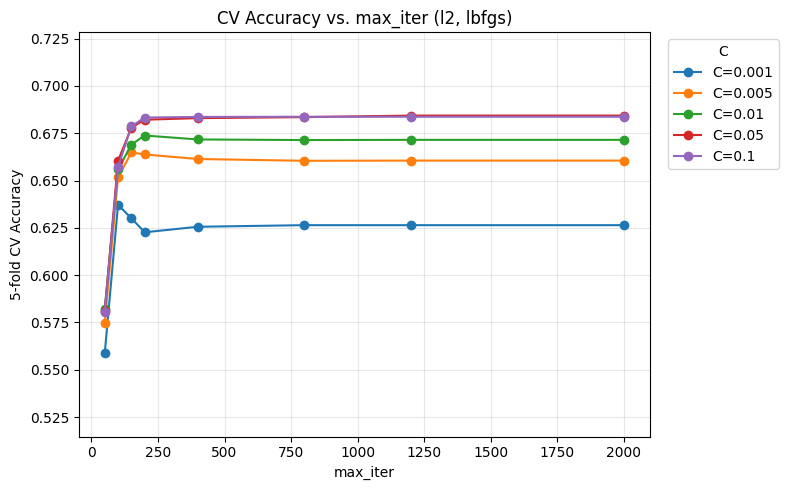

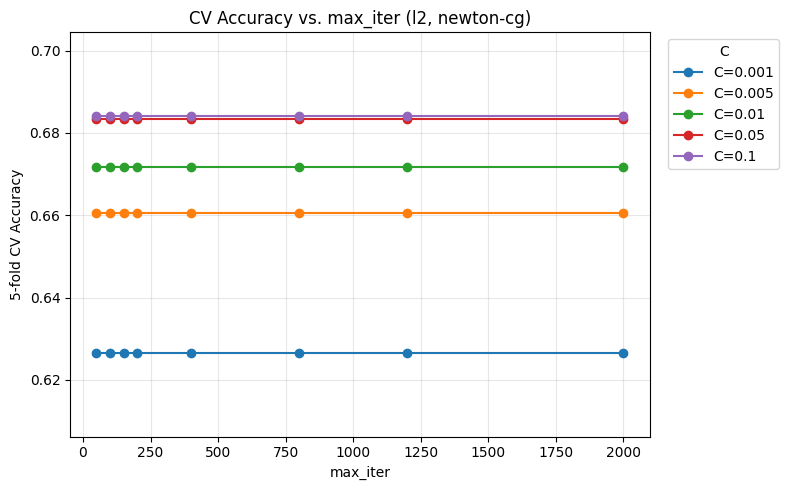

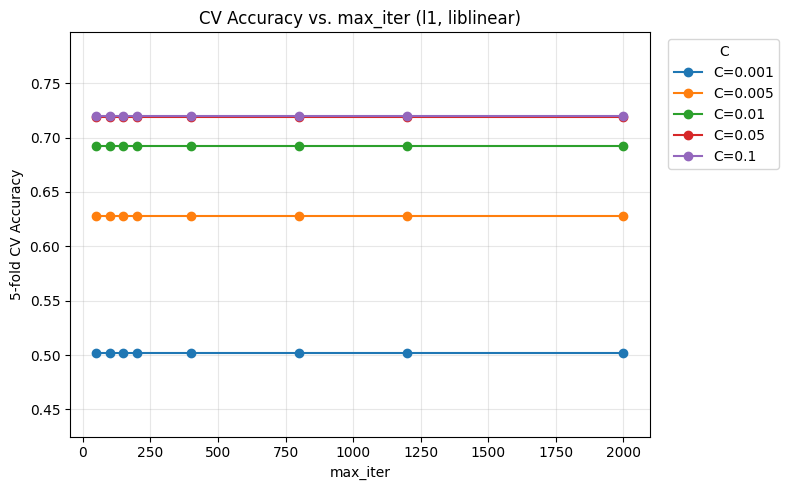

In [ ]:
for penalty, solver in penalty_solver_combos:
    subset = cv_iter_df[(cv_iter_df['penalty'] == penalty) & (cv_iter_df['solver'] == solver)]
    if subset.empty:
        continue

    fig, ax = plt.subplots(figsize=(8, 5))
    for C in C_values:
        curve = subset[subset['C'] == C].sort_values('max_iter')
        if curve.empty:
            continue
        ax.plot(
            curve['max_iter'],
            curve['cv_mean_accuracy'],
            marker='o',
            label=f"C={C}"
        )

    # Auto-scale the y-axis so small accuracy gains remain visible
    y_min = subset['cv_mean_accuracy'].min()
    y_max = subset['cv_mean_accuracy'].max()
    pad = max(0.0025, (y_max - y_min) * 0.35)
    lower = max(0.0, y_min - pad)
    upper = min(1.0, y_max + pad)

    ax.set_title(f"CV Accuracy vs. max_iter ({penalty}, {solver})")
    ax.set_xlabel("max_iter")
    ax.set_ylabel("5-fold CV Accuracy")
    ax.set_ylim(lower, upper)
    ax.grid(True, alpha=0.3)
    ax.legend(title="C", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### Best-Performing Curves Overlay
We extract the best `C` for each solver (highest CV accuracy at `max_iter=2000`) and plot them together to illustrate why the chosen configuration wins.

Selected C=0.05 for (l2, lbfgs) with CV Acc=0.6843 at max_iter=2000
Selected C=0.1 for (l2, newton-cg) with CV Acc=0.6842 at max_iter=2000
Selected C=0.1 for (l1, liblinear) with CV Acc=0.7202 at max_iter=2000


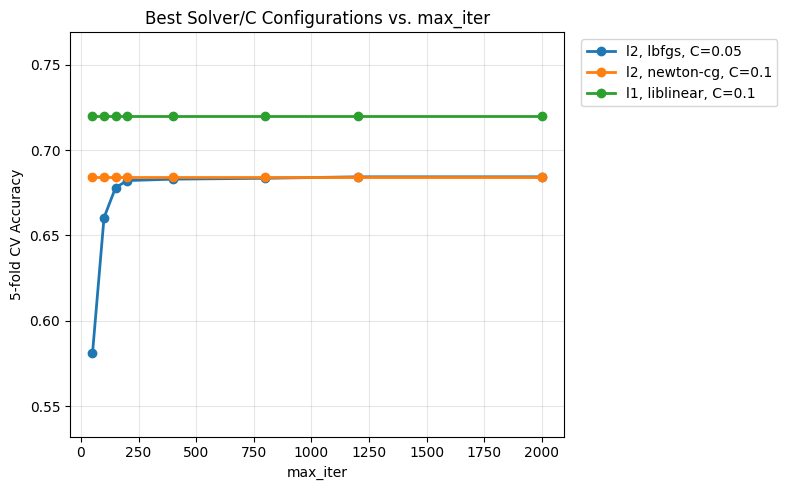

In [ ]:
best_curves = []
max_iter_max = max(max_iter_grid)

for penalty, solver in penalty_solver_combos:
    subset = cv_iter_df[(cv_iter_df['penalty'] == penalty) & (cv_iter_df['solver'] == solver)]
    if subset.empty:
        continue
    terminal = subset[subset['max_iter'] == max_iter_max]
    if terminal.empty:
        continue
    best_row = terminal.sort_values('cv_mean_accuracy', ascending=False).iloc[0]
    best_C = best_row['C']
    best_curve = subset[subset['C'] == best_C].sort_values('max_iter')
    best_curves.append((penalty, solver, best_C, best_curve))
    print(
        f"Selected C={best_C} for ({penalty}, {solver}) with CV Acc={best_row['cv_mean_accuracy']:.4f} at max_iter={max_iter_max}"
    )

if not best_curves:
    print("No curves available to plot.")
else:
    fig, ax = plt.subplots(figsize=(8, 5))
    all_values = []

    for penalty, solver, best_C, curve in best_curves:
        label = f"{penalty}, {solver}, C={best_C}"
        ax.plot(
            curve['max_iter'],
            curve['cv_mean_accuracy'],
            marker='o',
            linewidth=2,
            label=label
        )
        all_values.append(curve['cv_mean_accuracy'].values)

    stacked = np.concatenate(all_values)
    y_min = stacked.min()
    y_max = stacked.max()
    pad = max(0.0025, (y_max - y_min) * 0.35)
    lower = max(0.0, y_min - pad)
    upper = min(1.0, y_max + pad)

    ax.set_title("Best Solver/C Configurations vs. max_iter")
    ax.set_xlabel("max_iter")
    ax.set_ylabel("5-fold CV Accuracy")
    ax.set_ylim(lower, upper)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
# Evaluate top 5 models on VALIDATION set (not test!)
# This helps us pick the best model before final test evaluation

print("=" * 70)
print("VALIDATION SET EVALUATION (Top 5 CV models)")
print("=" * 70)

validation_results = []

for i, row in cv_results_df.head(5).iterrows():
    # Train model on full training set
    model = LogisticRegression(
        C=row['C'],
        penalty=row['penalty'],
        solver=row['solver'],
        class_weight='balanced',
        max_iter=2000,
        random_state=seed
    )
    model.fit(X_tr, y_tr)
    
    # Evaluate on training and validation sets
    train_acc = model.score(X_tr, y_tr)
    val_acc = model.score(X_val, y_val)
    
    validation_results.append({
        'C': row['C'],
        'penalty': row['penalty'],
        'solver': row['solver'],
        'cv_accuracy': row['cv_mean_accuracy'],
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'train_error': 1 - train_acc,
        'val_error': 1 - val_acc
    })
    
    print(f"\nConfig {i+1}: C={row['C']}, penalty={row['penalty']}, solver={row['solver']}")
    print(f"  CV Accuracy:    {row['cv_mean_accuracy']:.4f}")
    print(f"  Train Accuracy: {train_acc:.4f} (Error: {1-train_acc:.4f})")
    print(f"  Val Accuracy:   {val_acc:.4f} (Error: {1-val_acc:.4f})")

# Find best model based on validation accuracy
validation_df = pd.DataFrame(validation_results)
best_idx = validation_df['val_accuracy'].idxmax()
best_config = validation_df.loc[best_idx]

print("\n" + "=" * 70)
print("BEST MODEL (based on validation accuracy)")
print("=" * 70)
print(f"C = {best_config['C']}")
print(f"penalty = '{best_config['penalty']}'")
print(f"solver = '{best_config['solver']}'")
print(f"Validation Accuracy: {best_config['val_accuracy']:.4f}")
print(f"Validation Error Rate: {best_config['val_error']:.4f}")
print("=" * 70)
print("\n>>> Update the final model cell below with these hyperparameters! <<<")

VALIDATION SET EVALUATION (Top 5 CV models)


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



Config 1: C=0.1, penalty=l1, solver=liblinear
  CV Accuracy:    0.7202
  Train Accuracy: 0.8065 (Error: 0.1935)
  Val Accuracy:   0.7189 (Error: 0.2811)


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



Config 2: C=0.05, penalty=l1, solver=liblinear
  CV Accuracy:    0.7192
  Train Accuracy: 0.7757 (Error: 0.2243)
  Val Accuracy:   0.7204 (Error: 0.2796)


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



Config 3: C=0.01, penalty=l1, solver=liblinear
  CV Accuracy:    0.6922
  Train Accuracy: 0.7213 (Error: 0.2787)
  Val Accuracy:   0.6980 (Error: 0.3020)

Config 4: C=0.05, penalty=l2, solver=lbfgs
  CV Accuracy:    0.6843
  Train Accuracy: 0.8563 (Error: 0.1437)
  Val Accuracy:   0.6922 (Error: 0.3078)

Config 4: C=0.05, penalty=l2, solver=lbfgs
  CV Accuracy:    0.6843
  Train Accuracy: 0.8563 (Error: 0.1437)
  Val Accuracy:   0.6922 (Error: 0.3078)

Config 5: C=0.1, penalty=l2, solver=newton-cg
  CV Accuracy:    0.6842
  Train Accuracy: 0.8863 (Error: 0.1137)
  Val Accuracy:   0.6902 (Error: 0.3098)

BEST MODEL (based on validation accuracy)
C = 0.05
penalty = 'l1'
solver = 'liblinear'
Validation Accuracy: 0.7204
Validation Error Rate: 0.2796

>>> Update the final model cell below with these hyperparameters! <<<

Config 5: C=0.1, penalty=l2, solver=newton-cg
  CV Accuracy:    0.6842
  Train Accuracy: 0.8863 (Error: 0.1137)
  Val Accuracy:   0.6902 (Error: 0.3098)

BEST MODEL (based

### Final Logistic Regression Model
After running the hyperparameter search above, update the parameters below with the best configuration found, then run on the test set for final evaluation.

Testing parameters for validation accuracies: 27.95 (0.15), 27.65 (0.125), 27.12 (0.1), 31.06 (0.95), 31.11 (0.99 overtrained - train error lower test error higher) 
Found 0.1 is best

In [ ]:
logreg = LogisticRegression(
    C=0.1,
    penalty='l1',
    solver='liblinear',
    class_weight='balanced',
    max_iter=2000,
    random_state=seed
)

logreg.fit(X_tr, y_tr)

# Predict on all sets
y_tr_pred = logreg.predict(X_tr)
y_val_pred = logreg.predict(X_val)
y_te_pred = logreg.predict(X_te)

# Calculate error rates
y_tr_error_rate = np.mean(y_tr != y_tr_pred)
y_val_error_rate = np.mean(y_val != y_val_pred)
y_te_error_rate = np.mean(y_te != y_te_pred)

/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


In [ ]:
print(f"=== Logistic Regression Results ===")
print(f"Training Error Rate:   {y_tr_error_rate:.4f} ({y_tr_error_rate*100:.2f}%)")
print(f"Validation Error Rate: {y_val_error_rate:.4f} ({y_val_error_rate*100:.2f}%)")
print(f"Test Error Rate:       {y_te_error_rate:.4f} ({y_te_error_rate*100:.2f}%)")
print(f"\nNote: Use validation set for hyperparameter tuning.")
print(f"      Test set should only be used for final model evaluation!")

=== Logistic Regression Results ===
Training Error Rate:   0.1935 (19.35%)
Validation Error Rate: 0.2811 (28.11%)
Test Error Rate:       0.2712 (27.12%)

Note: Use validation set for hyperparameter tuning.
      Test set should only be used for final model evaluation!


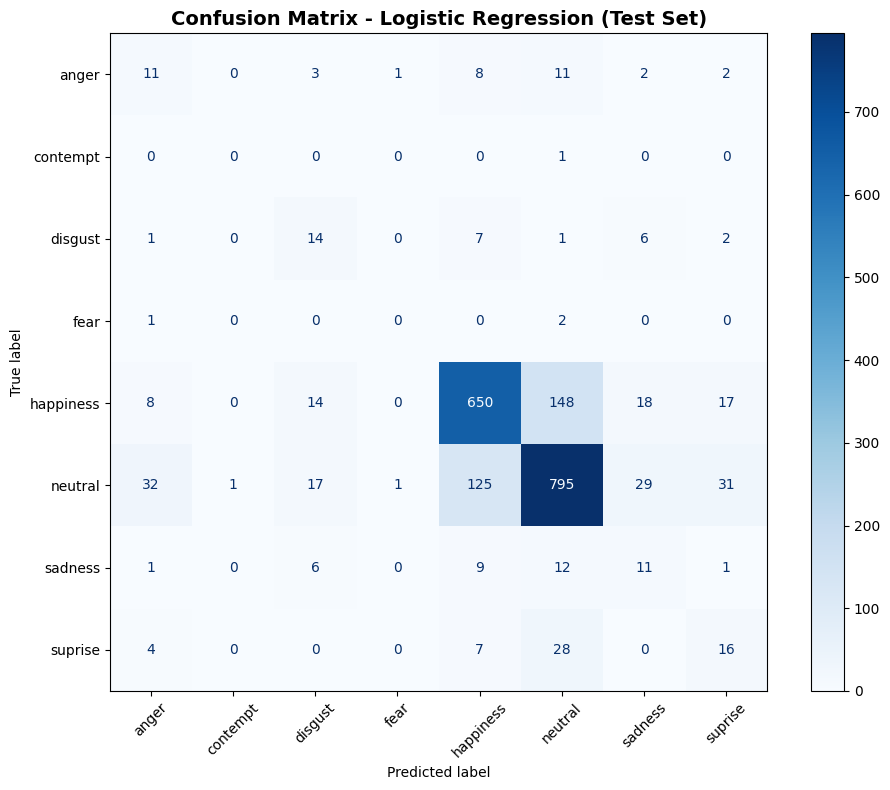


=== Per-Class Performance ===
anger       :   11/  38 correct (28.9%)
contempt    :    0/   1 correct (0.0%)
disgust     :   14/  31 correct (45.2%)
fear        :    0/   3 correct (0.0%)
happiness   :  650/ 855 correct (76.0%)
neutral     :  795/1031 correct (77.1%)
sadness     :   11/  40 correct (27.5%)
suprise     :   16/  55 correct (29.1%)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get unique emotion labels (sorted for consistent ordering)
emotion_labels = sorted(np.unique(y))

# Compute confusion matrix on test set
cm = confusion_matrix(y_te, y_te_pred, labels=emotion_labels)

# Display confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation=45)
ax.set_title('Confusion Matrix - Logistic Regression (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print per-class accuracy
print("\n=== Per-Class Performance ===")
for i, emotion in enumerate(emotion_labels):
    true_count = cm[i, :].sum()
    correct = cm[i, i]
    accuracy = correct / true_count if true_count > 0 else 0
    print(f"{emotion:12s}: {correct:4d}/{true_count:4d} correct ({accuracy*100:.1f}%)")

In [ ]:
# Save the trained Logistic Regression model to disk
# Uses joblib for efficient persistence of scikit-learn models
import os
import joblib

models_dir = os.path.join('.', 'models')
os.makedirs(models_dir, exist_ok=True)

model_file = os.path.join(models_dir, 'best_logreg.joblib')

# Save the model (LogisticRegression stored in variable 'logreg')
# If `logreg` isn't defined, this will raise an error when run; ensure 'logreg' is a trained model
joblib.dump(logreg, model_file)
print(f"Saved best LogisticRegression model to: {model_file}")


Saved best LogisticRegression model to: ./models/best_logreg.joblib


In [ ]:
# Demo: How to load the saved model from disk
# This shows how to reload a saved scikit-learn model using joblib.
# Note: This code assumes the file exists at the same path used when saving.
model_file = './models/best_logreg.joblib'

# If you wish to avoid actually loading when people run the cell, guard with a flag
LOAD_MODEL_DEMO = True

if LOAD_MODEL_DEMO:
    try:
        loaded_model = joblib.load(model_file)
        print(f"Loaded model from {model_file}; model type: {type(loaded_model)}")
    except FileNotFoundError:
        print(f"Model file not found at {model_file}. Run the save cell above to create it.")
    except Exception as e:
        print(f"An error occurred while loading the model: {e}")
else:
    print("Demo load skipped. Set LOAD_MODEL_DEMO = True to attempt loading the model.")

Loaded model from ./models/best_logreg.joblib; model type: <class 'sklearn.linear_model._logistic.LogisticRegression'>


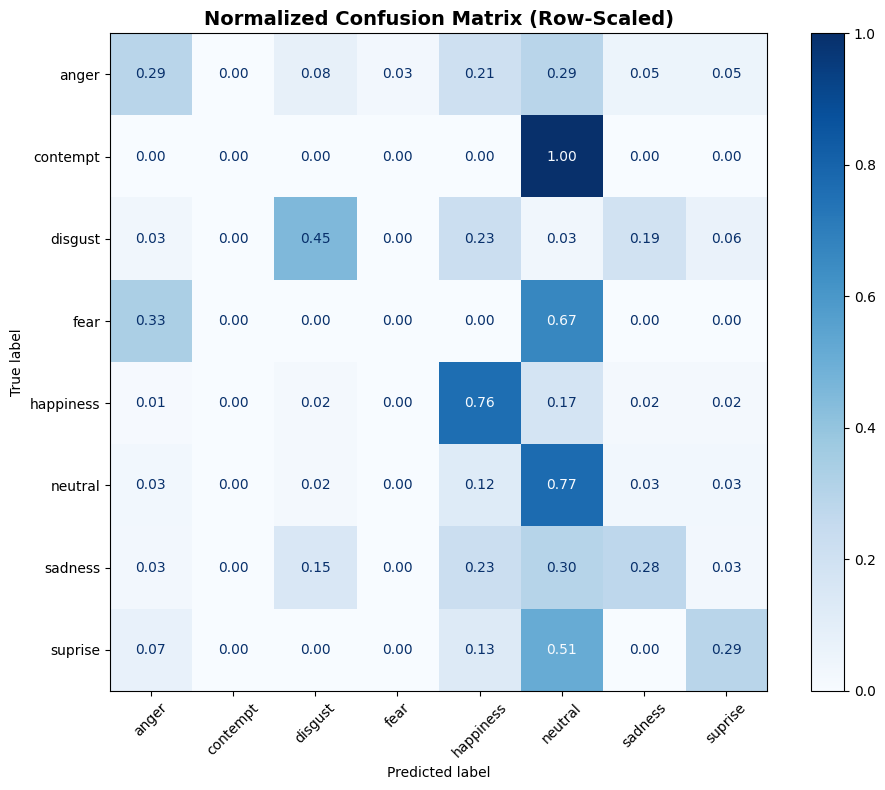

In [ ]:
import os
import joblib

# Load the saved model
model_path = os.path.join('.', 'models', 'best_logreg.joblib')
loaded_logreg = joblib.load(model_path)

# Predict on test set
y_te_pred_loaded = loaded_logreg.predict(X_te)

# Compute normalized confusion matrix (normalize='true' scales rows to sum to 1)
# This helps visualize per-class accuracy independent of class size
cm_norm = confusion_matrix(y_te, y_te_pred_loaded, labels=emotion_labels, normalize='true')

# Display normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=emotion_labels)

# Plot with values formatted as decimals (e.g., 0.85)
disp.plot(ax=ax, cmap='Blues', values_format='.2f', xticks_rotation=45)

ax.set_title('Normalized Confusion Matrix (Row-Scaled)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Standard First CNN Implementation (128x128)
Handling 128x128 scaled images with no augmentation nor tuning. Copied from separate ipynb.

### Imports
Below we import all required libraries for loading images, preprocessing,
building the CNN, and training it using PyTorch.


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


### Load & Preprocess Images (Grayscale 128×128)
We load each image, convert it to grayscale, resize it to 128×128, normalize
pixel values to [0,1], and expand to shape (1,128,128) for CNN input.


In [ ]:
IMG_SIZE = 128
base_path = "."
images_folder = os.path.join(base_path, "images")
csv_file = os.path.join(base_path, "legend.csv")

df = pd.read_csv(csv_file)

images = []
labels = []

print("Loading images...")

for idx, row in df.iterrows():
    img_name = row['image']
    emotion = row['emotion']
    
    img_path = os.path.join(images_folder, img_name)

    # Load in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Warning: could not load", img_path)
        continue
    
    # Resize for CNN
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Normalize to [0,1]
    img = img / 255.0
    
    # Add channel dimension → (1,128,128)
    img = np.expand_dims(img, axis=0)

    images.append(img)
    labels.append(emotion)

X = np.array(images, dtype=np.float32)
y = np.array(labels)

print("Finished loading images!")
print("X shape:", X.shape)   # Expected: (N, 1, 128, 128)
print("y shape:", y.shape)   # Expected: (N,)


Loading images...
Finished loading images!
X shape: (13690, 1, 128, 128)
y shape: (13690,)


### Label Encoding
We convert emotion labels (strings) into integer class IDs (0–6)
and store the mapping for later use.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

num_classes = len(le.classes_)

print("Classes:", le.classes_)
print("Number of classes =", num_classes)
print("Sample encoded labels:", y_encoded[:10])

Classes: ['anger' 'contempt' 'disgust' 'fear' 'happiness' 'neutral' 'sadness'
 'suprise']
Number of classes = 8
Sample encoded labels: [0 7 2 3 5 4 5 4 4 4]


### Train / Validation / Test Split

We split the dataset into three parts:

- **70% Training**
- **15% Validation**
- **15% Testing**

We use *stratified sampling* to ensure that all 8 emotion classes maintain their proportions across the splits. This avoids issues where rare classes (e.g., *contempt*, *suprise*) disappear from validation or test sets.


In [ ]:
from sklearn.model_selection import train_test_split

# 70% train, 30% temp split
X_tr, X_temp, y_tr, y_temp = train_test_split(
    X, y_encoded,
    test_size=0.30,
    stratify=y_encoded,
    random_state=123
)

# Split temp 30% into 15% val + 15% test
X_val, X_te, y_val, y_te = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=123
)

print("Train:", X_tr.shape, "Labels:", y_tr.shape)
print("Val:  ", X_val.shape, "Labels:", y_val.shape)
print("Test: ", X_te.shape, "Labels:", y_te.shape)


Train: (9583, 1, 128, 128) Labels: (9583,)
Val:   (2053, 1, 128, 128) Labels: (2053,)
Test:  (2054, 1, 128, 128) Labels: (2054,)


### PyTorch Dataset and DataLoaders

To train a CNN efficiently, we convert our NumPy arrays into PyTorch tensors.
We create a custom `EmotionDataset` class that:

- Stores images and labels
- Converts them into PyTorch tensors
- Returns `(image, label)` pairs

We then wrap these in `DataLoader` objects to enable:

- Mini-batching
- Shuffling
- Fast loading during training


In [ ]:
# Custom PyTorch Dataset for Emotion Images
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # shape: (N, 1, 128, 128)
        self.y = torch.tensor(y, dtype=torch.long)     # class IDs (0–7)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
batch_size = 64

train_loader = DataLoader(EmotionDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(EmotionDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(EmotionDataset(X_te, y_te), batch_size=batch_size, shuffle=False)

# Quick sanity check
for images, labels in train_loader:
    print("Batch image shape:", images.shape)   # expected: (64, 1, 128, 128)
    print("Batch label shape:", labels.shape)   # expected: (64,)
    break


Batch image shape: torch.Size([64, 1, 128, 128])
Batch label shape: torch.Size([64])


### Define the EmotionCNN Model

We construct a deeper convolutional neural network suitable for 128×128
grayscale emotion images. The architecture includes:

- Three convolutional blocks (Conv → ReLU → MaxPool)
- Increasing filter sizes (32, 64, 128)
- Dropout for regularization
- Two fully connected layers
- Output layer with 8 logits corresponding to the 8 emotion classes

This model is significantly more expressive than the homework CNN and 
should perform better on complex visual emotion recognition tasks.


In [ ]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionCNN, self).__init__()

        # ---- Convolutional Block 1 ----
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128 → 64

        # ---- Convolutional Block 2 ----
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64 → 32

        # ---- Convolutional Block 3 ----
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32 → 16

        # ---- Fully Connected Layers ----
        # After 3 pools: 128 feature maps of size 16×16
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Block 1
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # Block 2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # Block 3
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # logits

        return x


In [ ]:
model = EmotionCNN(num_classes=num_classes)
print(model)


EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=8, bias=True)
)


### Training the CNN

We now train the `EmotionCNN` model using:

- **CrossEntropyLoss** (standard for multi-class classification)
- **Adam optimizer**
- **Mini-batch training**
- **Training and validation accuracy tracking**

This section will also produce loss and accuracy curves to evaluate
underfitting vs overfitting.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = EmotionCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Tracking
train_losses = []
val_losses = []
train_accs = []
val_accs = []

epochs = 15  # start with 15; you can increase later

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Training accuracy
        _, predicted = outputs.max(1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            _, predicted = outputs.max(1)
            val_correct += (predicted == y_batch).sum().item()
            val_total += y_batch.size(0)
    
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Acc: {train_accs[-1]:.3f} | "
          f"Val Acc: {val_accs[-1]:.3f}")


Using device: cpu
Epoch 1/15 | Train Acc: 0.592 | Val Acc: 0.767
Epoch 2/15 | Train Acc: 0.732 | Val Acc: 0.749
Epoch 3/15 | Train Acc: 0.741 | Val Acc: 0.793
Epoch 4/15 | Train Acc: 0.769 | Val Acc: 0.804
Epoch 5/15 | Train Acc: 0.783 | Val Acc: 0.818
Epoch 6/15 | Train Acc: 0.793 | Val Acc: 0.817
Epoch 7/15 | Train Acc: 0.804 | Val Acc: 0.824
Epoch 8/15 | Train Acc: 0.811 | Val Acc: 0.818
Epoch 9/15 | Train Acc: 0.812 | Val Acc: 0.793
Epoch 10/15 | Train Acc: 0.822 | Val Acc: 0.832
Epoch 11/15 | Train Acc: 0.828 | Val Acc: 0.829
Epoch 12/15 | Train Acc: 0.827 | Val Acc: 0.833
Epoch 13/15 | Train Acc: 0.828 | Val Acc: 0.830
Epoch 14/15 | Train Acc: 0.833 | Val Acc: 0.814
Epoch 15/15 | Train Acc: 0.836 | Val Acc: 0.823


### Performance Curves and Test Evaluation

After training the CNN for 15 epochs, we visualize the model's learning
behavior by plotting:

- Training vs Validation Loss
- Training vs Validation Accuracy

These curves help diagnose underfitting or overfitting. Finally, we
evaluate the model on the held-out test set to obtain an unbiased estimate
of performance.


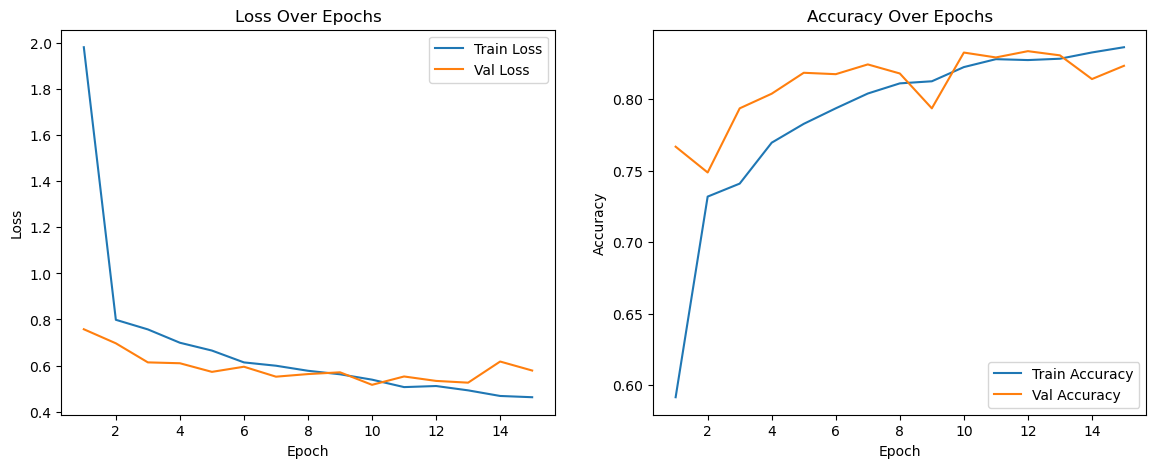

In [ ]:
# Plot curves
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# ---- Loss Plot ----
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# ---- Accuracy Plot ----
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Train Accuracy')
plt.plot(epochs_range, val_accs, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.show()


In [ ]:
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = outputs.max(1)
        test_correct += (predicted == y_batch).sum().item()
        test_total += y_batch.size(0)

test_acc = test_correct / test_total
test_err = 1 - test_acc

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Error Rate: {test_err:.4f}")


Test Accuracy: 0.8199
Test Error Rate: 0.1801


### Confusion Matrix

To understand which emotions the model confuses, we compute a confusion
matrix over the test set. This helps visualize performance per class and
identify difficult emotion categories.


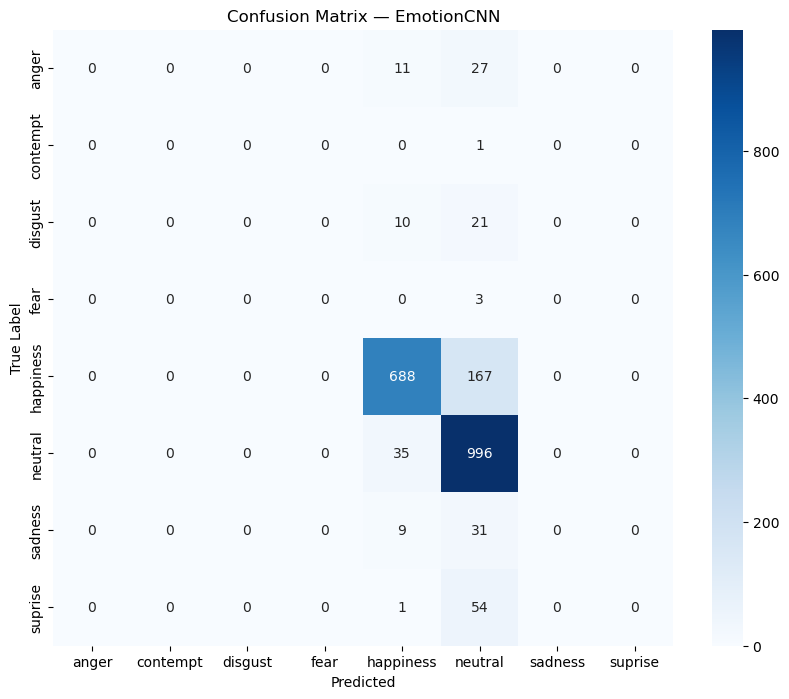

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix — EmotionCNN")
plt.show()


## **Augmentation Toolkit**
- Build reusable helpers for diverse geometric/photometric transforms.
- Plan to oversample only the training split so each emotion reaches the same count as the majority class (typically happiness/neutral).

In [ ]:
def apply_random_transforms(img, rng):
    """Apply a diverse set of randomized geometric and photometric transforms."""
    augmented = img.astype(np.float32) # copy to be transformed

    # randomly horizontal flip with 50%
    if rng.random() < 0.5:
        augmented = np.fliplr(augmented)

    # random rotation between -15 and 15 degrees
    angle = rng.uniform(-15, 15)
    augmented = rotate(augmented, angle=angle, reshape=False, mode='reflect')

    # random brightness/contrast jitter with 60% chance
    if rng.random() < 0.6:
        alpha = rng.uniform(0.85, 1.25)  # contrast
        beta = rng.uniform(-12, 12)      # brightness
        augmented = alpha * augmented + beta

    # light sharpening with 15% chance
    if rng.random() < 0.15:
        blurred = cv2.GaussianBlur(augmented, (3, 3), 0)
        augmented = np.clip(augmented + 0.3 * (augmented - blurred), 0, 255)

    # add gaussian noise with 40% chance
    if rng.random() < 0.4:
        noise = rng.normal(0, 8, augmented.shape)
        augmented = augmented + noise

    # random linear translation with 40% chance
    if rng.random() < 0.4:
        tx = int(rng.integers(-4, 5))
        ty = int(rng.integers(-4, 5))
        transform_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
        augmented = cv2.warpAffine(
            augmented,
            transform_matrix,
            (IMG_SIZE, IMG_SIZE),
            borderMode=cv2.BORDER_REFLECT101
        )
        
    # clip to valid pixel range and return
    augmented = np.clip(augmented, 0, 255)
    return augmented.astype(np.float32)

def balance_classes_with_augmentation(X, y, target_count=None, rng_seed=seed):
    """Augment only the provided split (training split, usually) until every class reaches target_count samples."""
    X = np.asarray(X)
    y = np.asarray(y)

    # count samples per class
    class_counts = pd.Series(y).value_counts().sort_index()
    # get sample count for happiness and neutral and save to anchor counts
    anchor_counts = [class_counts.get(label, class_counts.max()) for label in ("happiness", "neutral")]
    # target = anchor + max class counts if target is None
    default_target = max(anchor_counts + [class_counts.max()])
    target_count = target_count or default_target
    # in our actual implementation we set target_count just to max() of class counts below

    rng = np.random.default_rng(rng_seed)
    new_samples = []
    new_labels = []

    # for each class, add augmented samples if needed
    for label, count in class_counts.items():
        needed = int(max(0, target_count - count))
        if needed == 0:
            continue

        label_indices = np.where(y == label)[0]
        for _ in range(needed):
            # choose random base index, copy and augment it
            base_idx = rng.choice(label_indices)
            base_img = X[base_idx].reshape(IMG_SIZE, IMG_SIZE)
            augmented_img = apply_random_transforms(base_img, rng)
            # add to new samples and new labels together to keep in order
            new_samples.append(augmented_img.flatten())
            new_labels.append(label)

    # add existing augmented samples with originals
    if new_samples:
        # vertical stack for X data
        augmented_X = np.vstack((X.astype(np.float32), np.array(new_samples, dtype=np.float32)))
        # basic concatenate for y data
        augmented_y = np.concatenate((y, np.array(new_labels)))
    else:
        # if none exist then just set augmented to existing X and y without adding anything
        augmented_X = X.astype(np.float32)
        augmented_y = y

    # count after augmentation
    augmented_counts = pd.Series(augmented_y).value_counts().sort_index()
    return augmented_X, augmented_y, class_counts, augmented_counts, target_count

In [ ]:
# summarize the counts of our current dataset and display
def summarize_counts(labels, title):
    counts = pd.Series(labels).value_counts().sort_index()
    print(f"=== {title} ===")
    print(counts)
    print(f"Total samples: {counts.sum():,}\n")
    return counts
base_counts = summarize_counts(y, "Original dataset distribution")

# find anchor target by finding maximum class size
anchor_target = max(
    base_counts.get("happiness", base_counts.max()),
    base_counts.get("neutral", base_counts.max())
)
print(f"Anchor target per class (matching happiness/neutral): {anchor_target}")

=== Original dataset distribution ===
anger         252
contempt        9
disgust       208
fear           21
happiness    5696
neutral      6868
sadness       268
suprise       368
Name: count, dtype: int64
Total samples: 13,690

Anchor target per class (matching happiness/neutral): 6868


In [ ]:
"""A set of previewing and plotting functions 
to show what augmentation is doing"""

def plot_class_counts(before_counts, after_counts, title):
    # get sorted list of all unique labels from before & after
    labels = sorted(set(before_counts.index).union(after_counts.index))
    # get counts for each label before and after augmentation
    before = [before_counts.get(lbl, 0) for lbl in labels]
    after = [after_counts.get(lbl, 0) for lbl in labels]

    # bar chart bar attributes
    x = np.arange(len(labels))
    width = 0.35  # bar width

    plt.figure(figsize=(12, 5))
    # plot bars for before counts
    plt.bar(x - width / 2, before, width, label="Before")
    # plot bars for after counts
    plt.bar(x + width / 2, after, width, label="After")
    # plot x-ticks as emotion labels diagonally
    plt.xticks(x, labels, rotation=45)
    plt.ylabel("Samples")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def preview_random_augmentations(X, y, label=None, samples=3, rng_seed=seed):
    # create random generator for reproducibility
    rng = np.random.default_rng(rng_seed)
    # pick a label if not provided
    if label is None:
        label = rng.choice(np.unique(y))

    # find indices for the selected label
    label_indices = np.where(y == label)[0]
    if len(label_indices) == 0:
        print(f"Label '{label}' not found in the provided data.")
        return
    
    plt.figure(figsize=(samples * 3, 4)) # longer for more samples

    for i in range(samples):
        # pick a random index for the label
        idx = rng.choice(label_indices)
        # reshape flat image to 2d
        original_img = X[idx].reshape(IMG_SIZE, IMG_SIZE)
        # apply augmentation
        augmented_img = apply_random_transforms(original_img, rng)

        # create subplot of 2 rows, 'samples' columns
        plt.subplot(2, samples, i + 1) # select 1st cell
        # plot original image in 1st cel
        plt.imshow(original_img, cmap="gray")
        plt.axis("off")
        plt.title(f"{label} original")

        # plot augmented image in cell + 1
        plt.subplot(2, samples, samples + i + 1)
        plt.imshow(augmented_img, cmap="gray")
        plt.axis("off")
        plt.title(f"{label} augmented")

    plt.suptitle(f"Random augmentations for '{label}'")
    plt.tight_layout()
    plt.show()

Previewing augmentation effects for minority label: contempt


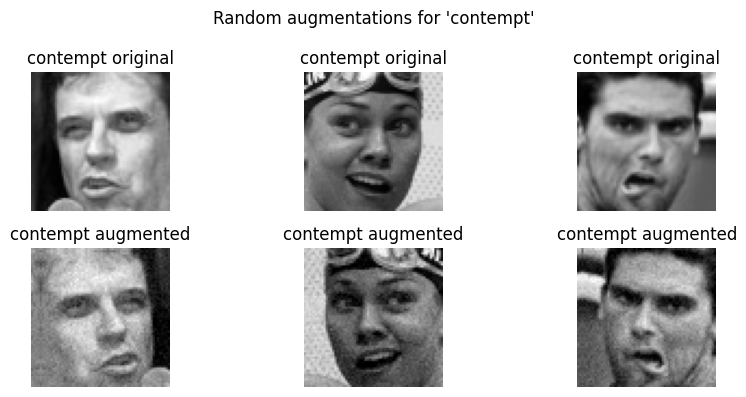


Previewing augmentation effects for common label: happiness


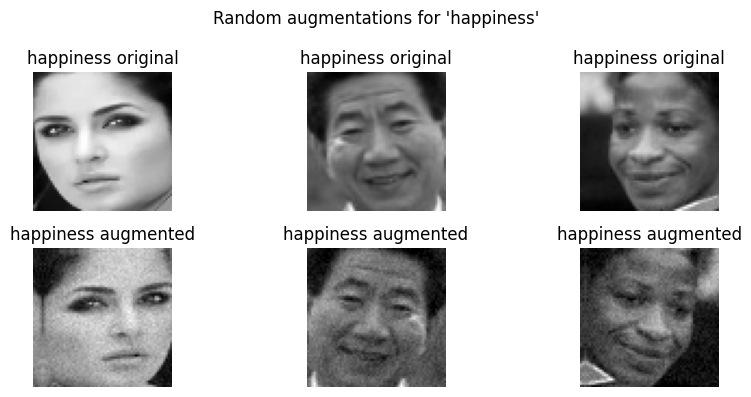

In [ ]:
# find the rarest label (minority class) and a common label for augmentation preview
rare_label = base_counts.idxmin()
common_label = "happiness" if "happiness" in base_counts.index else base_counts.idxmax()

# show augmentation effects for the rare label
print(f"Previewing augmentation effects for minority label: {rare_label}")
preview_random_augmentations(X, y, label=rare_label, samples=3)

# show augmentation effects for the common label
print(f"\nPreviewing augmentation effects for common label: {common_label}")
preview_random_augmentations(X, y, label=common_label, samples=3)

In [ ]:
# calculate how many augmented extra samples are needed per label sorted descending
needed_per_label = base_counts.apply(lambda c: max(0, anchor_target - c)).sort_values(ascending=False)
print("=== Samples needed per label to match anchor target ===")
print(needed_per_label)
print("\nThese counts determine how many synthetic examples each class will receive once we augment the training split.")

=== Samples needed per label to match anchor target ===
contempt     6859
fear         6847
disgust      6660
anger        6616
sadness      6600
suprise      6500
happiness    1172
neutral         0
Name: count, dtype: int64

These counts determine how many synthetic examples each class will receive once we augment the training split.


### Balanced augmentation strategy

- All images remain grayscale 64×64, but we now apply a richer transform palette: random flips, ±15° rotations, brightness/contrast jitter, Gaussian blur or sharpening, small translations, and gentle Gaussian noise. Each call produces a unique variant rather than deterministic duplicates.
- We only augment the **training split**. Validation and test images stay untouched so performance estimates remain honest.
- Every class is oversampled until it matches the anchor size defined by the most common label (`happiness` or `neutral` in this dataset). Rare emotions therefore receive more synthetic samples than already-balanced ones.
- Augmented samples are concatenated with the original training set before scaling; `StandardScaler` is still fit exclusively on that (now larger) training data and then applied to validation/test splits.
- Helper utilities report class counts before/after augmentation and let us visualize random augmented examples for any label to ensure the transforms look reasonable.

## Training Data (Re)Splitting after Augmentation

=== Data Split Summary ===
Training set:   9,583 samples (70.0%)
Validation set: 2,053 samples (15.0%)
Test set:       2,054 samples (15.0%)
Total:          13,690 samples

=== Training split counts before augmentation ===
anger         176
contempt        6
disgust       146
fear           15
happiness    3987
neutral      4807
sadness       188
suprise       258
Name: count, dtype: int64

Target per class for training augmentation: 4807

=== Training split counts after augmentation ===
anger        4807
contempt     4807
disgust      4807
fear         4807
happiness    4807
neutral      4807
sadness      4807
suprise      4807
Name: count, dtype: int64
Total augmented training samples: 38,456 (added 28,873)

=== Training split counts after augmentation ===
anger        4807
contempt     4807
disgust      4807
fear         4807
happiness    4807
neutral      4807
sadness      4807
suprise      4807
Name: count, dtype: int64
Total augmented training samples: 38,456 (added 28,873)


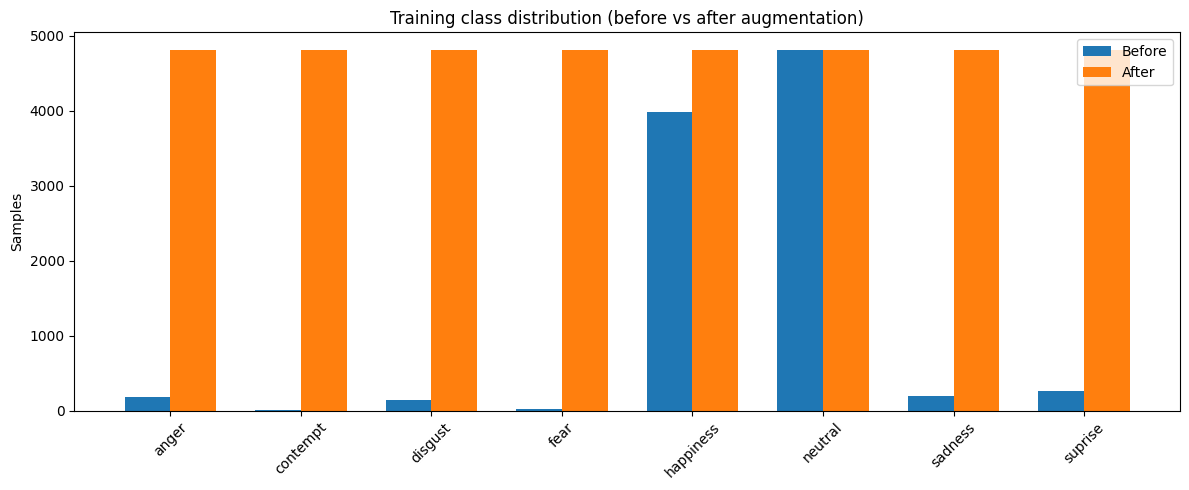

Scaling complete. Validation/test sets remain unaugmented to avoid leakage.


In [ ]:
# Split strategy: 70% train, 15% validation, 15% test
# Using stratified sampling to maintain class proportions (for imbalanced "disgust" class)

# First split: 70% train, 30% temp (which will become val + test)
X_tr, X_temp, y_tr, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=seed,
    shuffle=True,
    stratify=y
)

# Second split: Split the 30% temp into 50/50 -> 15% val, 15% test
X_val, X_te, y_val, y_te = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=seed,
    shuffle=True,
    stratify=y_temp
)

# Print shapes of training splits
print("=== Data Split Summary ===")
print(f"Training set:   {X_tr.shape[0]:,} samples ({X_tr.shape[0] / len(X) * 100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0] / len(X) * 100:.1f}%)")
print(f"Test set:       {X_te.shape[0]:,} samples ({X_te.shape[0] / len(X) * 100:.1f}%)")
print(f"Total:          {len(X):,} samples\n")

# Calculate training data before label counts
train_counts_before = pd.Series(y_tr).value_counts().sort_index()
print("=== Training split counts before augmentation ===")
print(train_counts_before)

# Set target equal to maximum between the two most common emotions
train_target = max(
    train_counts_before.get("happiness", train_counts_before.max()),
    train_counts_before.get("neutral", train_counts_before.max())
)
print(f"\nTarget per class for training augmentation: {train_target}")

# Run balancing function
X_tr_bal, y_tr_bal, before_counts, after_counts, _ = balance_classes_with_augmentation(
    X_tr,
    y_tr,
    target_count=train_target,
    rng_seed=seed
)

# Plot the result afterward
print("\n=== Training split counts after augmentation ===")
print(after_counts)
print(f"Total augmented training samples: {X_tr_bal.shape[0]:,} (added {X_tr_bal.shape[0] - X_tr.shape[0]:,})")

plot_class_counts(before_counts, after_counts, "Training class distribution (before vs after augmentation)")

# Scaling - fit ONLY on the augmented training data, transform all sets
scaler = StandardScaler()
scaler.fit(X_tr_bal)
X_tr = scaler.transform(X_tr_bal)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_te)
y_tr = y_tr_bal

print("Scaling complete. Validation/test sets remain unaugmented to avoid leakage.")

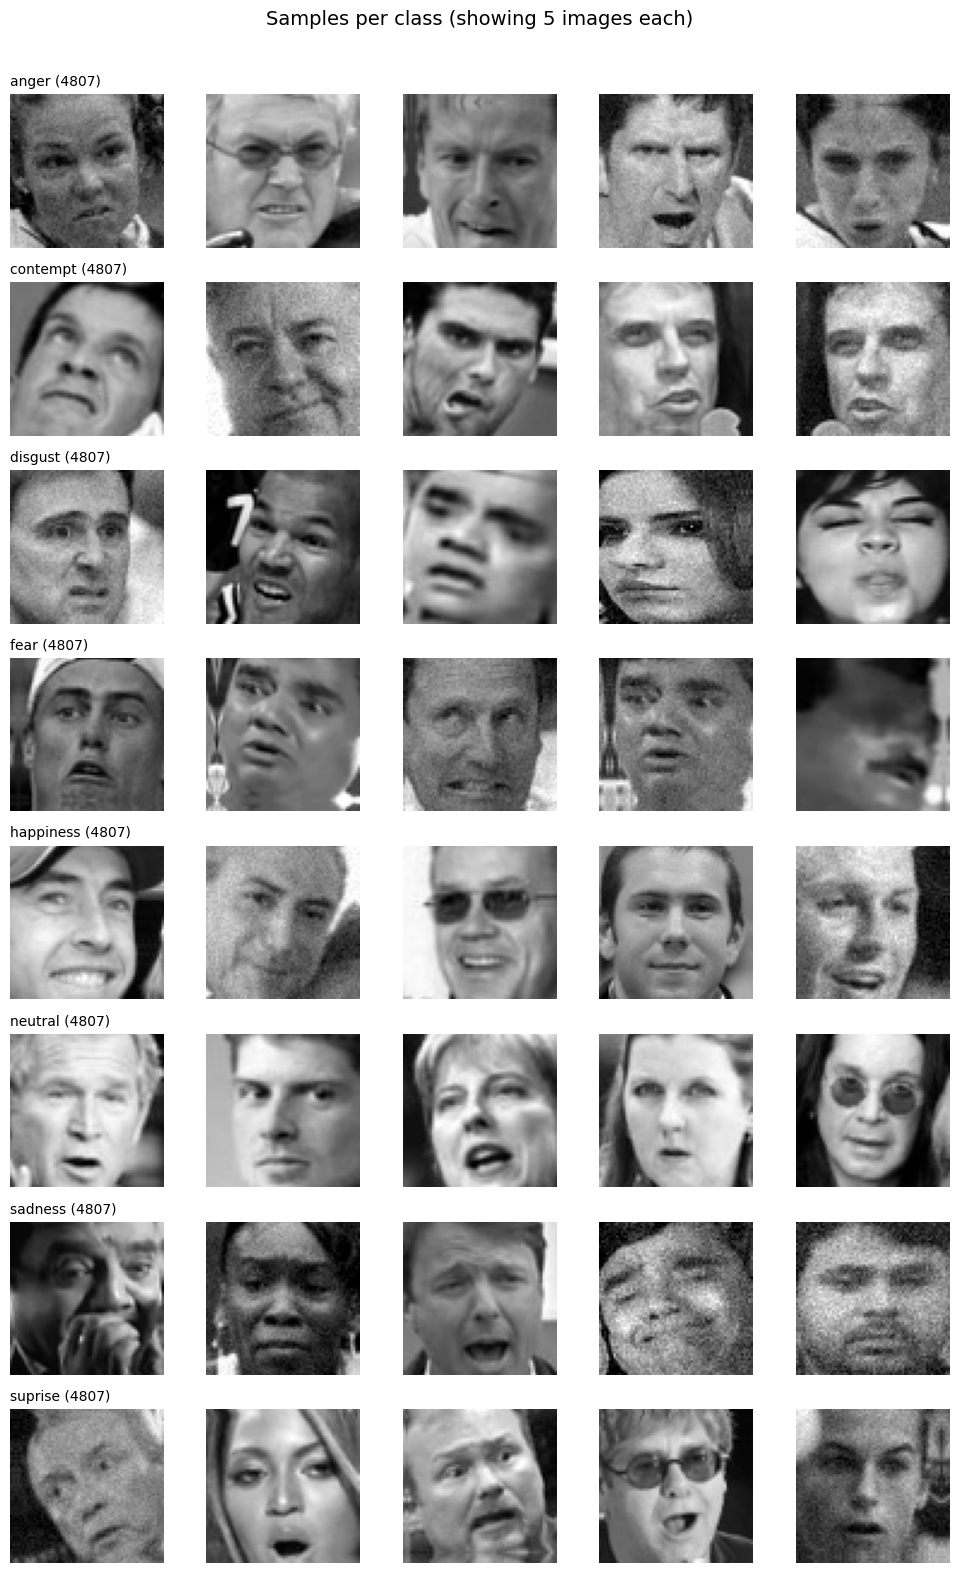

In [ ]:
def plot_samples_per_class(X, y, classes=None, samples_per_class=5, seed=seed):
    # plot a grid of sample images for each class
    classes = list(classes) if classes is not None else sorted(np.unique(y))  # get class list
    rng = np.random.default_rng(seed)  # reproducible random generator

    n_classes = len(classes)  # number of classes
    cols = samples_per_class  # columns per class
    rows = n_classes          # rows = number of classes

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.0, rows * 2.0))  # create subplot grid
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])  # handle single image case
    elif rows == 1:
        axes = axes[np.newaxis, :]  # handle single row
    elif cols == 1:
        axes = axes[:, np.newaxis]  # handle single column

    for i, cls in enumerate(classes):  # loop over each class
        idxs = np.where(y == cls)[0]  # find all indices for current class
        if idxs.size == 0:
            for j in range(cols):
                ax = axes[i, j]
                ax.axis("off")  # hide axes if no samples for some class
            continue

        if idxs.size >= cols:
            sel = rng.choice(idxs, size=cols, replace=False)  # select samples without replacement
        else:
            sel = rng.choice(idxs, size=cols, replace=True)   # select with replacement if not enough

        for j in range(cols):  # loop over selected samples
            ax = axes[i, j]
            img = X[sel[j]].reshape((IMG_SIZE, IMG_SIZE))  # reshape flat image
            # if image is float, normalize for display
            if np.issubdtype(img.dtype, np.floating):
                if img.max() > img.min():
                    img_disp = (img - img.min()) / (img.max() - img.min())  # scale to 0-1 based on range
                else:
                    img_disp = img  # name change to display scaled image
                ax.imshow(img_disp, cmap="gray")  # show grayscale image
            else:
                ax.imshow(img, cmap="gray", vmin=0, vmax=255)  # show uint8 image
            ax.axis("off")  # hide axis ticks
            if j == 0:
                ax.set_title(f"{cls} ({len(idxs)})", fontsize=10, loc="left")  # show class label

    plt.suptitle(f"Samples per class (showing {samples_per_class} images each)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # adjust layout
    plt.show()  # display plot


# Preview 5 images per class from the original dataset
labels_unique = sorted(np.unique(y_tr_bal))
plot_samples_per_class(X_tr_bal, y_tr_bal, classes=labels_unique, samples_per_class=5)

In [ ]:
models_dir = os.path.join(base_path, "models")
os.makedirs(models_dir, exist_ok=True)

# a function to save model checkpoints over epochs to ./models directory
def save_model_checkpoint(model: nn.Module, prefix: str, epoch: int, is_best: bool = False) -> str:
    """Persist model weights (CPU tensors) under ./models with an epoch or best suffix."""
    tag = "best" if is_best else f"epoch_{epoch:02d}"
    path = os.path.join(models_dir, f"{prefix}_{tag}.joblib")
    state_dict_cpu = OrderedDict((k, v.detach().cpu()) for k, v in model.state_dict().items())
    payload = {
        "epoch": int(epoch),
        "state_dict": state_dict_cpu,
        "prefix": prefix,
    }
    joblib.dump(payload, path, compress=3)
    return path

## Augmented CNN on Augmented 64×64 Data
We now use Nickolas' augmented training split to train Mihir's PyTorch CNN with images resized to 64×64. We normalize them to [0,1], and keep validation/test data untouched by augmentation to preserve proper evaluation.


In [ ]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader

# reshape and normalize 350x350 255-scaled images for CNN input
def reshape_and_normalize(flat_images):
    images = flat_images.reshape(-1, 1, IMG_SIZE, IMG_SIZE).astype(np.float32)
    return images / 255.0

# X_tr_bal is not scaled by StandardScaler
# X_tr IS. But we reshape and normalize just X_tr_bal, 
# the original values plus augments
X_tr_cnn = reshape_and_normalize(X_tr_bal)

# These other two sets of data (X_val, X_te) have been
# standard scaled, so inverse the scaling and then 
# reshape and normalize
X_val_unscaled = scaler.inverse_transform(X_val)
X_te_unscaled = scaler.inverse_transform(X_te)
X_val_cnn = reshape_and_normalize(X_val_unscaled)
X_te_cnn = reshape_and_normalize(X_te_unscaled)

# encode emotion labels as integers rather than emotions
# fit then transform all sets of labels
le = LabelEncoder()
le.fit(y)
y_tr_enc = le.transform(y_tr_bal)
y_val_enc = le.transform(y_val)
y_te_enc = le.transform(y_te)

print("CNN tensors ready:")
print(f"Train: {X_tr_cnn.shape} | Val: {X_val_cnn.shape} | Test: {X_te_cnn.shape}")
print("Classes:", le.classes_)

CNN tensors ready:
Train: (38456, 1, 64, 64) | Val: (2053, 1, 64, 64) | Test: (2054, 1, 64, 64)
Classes: ['anger' 'contempt' 'disgust' 'fear' 'happiness' 'neutral' 'sadness'
 'suprise']


In [ ]:
batch_size = 128  # batch size for DataLoader
pin_memory_flag = torch.cuda.is_available()  # use pinned memory if CUDA is available

# Pytorch tensors
train_dataset = TensorDataset(torch.tensor(X_tr_cnn), torch.tensor(y_tr_enc, dtype=torch.long))  # training set
val_dataset = TensorDataset(torch.tensor(X_val_cnn), torch.tensor(y_val_enc, dtype=torch.long))  # validation set
test_dataset = TensorDataset(torch.tensor(X_te_cnn), torch.tensor(y_te_enc, dtype=torch.long))  # test set

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=pin_memory_flag)  # train loader
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory_flag)  # val loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory_flag)  # test loader

for images, labels in train_loader:  # show sample batch of training data shape
    print("Sample batch:", images.shape, labels.shape)
    break
# should be 128 images of 1x64x64 flat output values and also just 128 labels
# 1 channel images introduce the "1x", RGB could have 3-channels as their data values
# so it would be 128x3x64x64

Sample batch: torch.Size([128, 1, 64, 64]) torch.Size([128])


In [ ]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # First convolutional layer: input 1 channel (grayscale), 
        # output 32 channels of 3x3 kernels with padding = 1
        # padding = 1 maintains data 64x64 dimension, just increase channels
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalize outputs of first conv layer

        # Second convolutional layer: input 32, output 64 feature maps, 3x3 kernel, padding=1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalize for second conv layer

        # Third convolutional layer: input 64, output 128 feature maps, 3x3 kernel, padding=1
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalize for third conv layer

        # Max pooling layer: reduces spatial dimensions by factor of 2 (kernel size 2x2)
        # Done between every layer in the forward function
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout layer: randomly zeroes 50% of features to reduce overfitting
        # Done before the final output layer, prevents overreliance on any features
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer: input is 128*8*8 (after 3 pools), output 256 features
        self.fc1 = nn.Linear(128 * 8 * 8, 256)

        # Final linear layer: maps 256 features to num_classes (emotion categories)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Layer 1: Conv -> BN -> ReLU -> MaxPool
        # Apply from inside outward!
        x = self.pool(F.relu(self.bn1(self.conv1(x)))
        )
        # Layer 2: Conv -> BN -> ReLU -> MaxPool
        x = self.pool(F.relu(self.bn2(self.conv2(x)))
        )
        # Layer 3: Conv -> BN -> ReLU -> MaxPool
        x = self.pool(F.relu(self.bn3(self.conv3(x)))
        )
        # Flatten for fully connected layers
        x = torch.flatten(x, 1)
        # FC1: Dense -> ReLU -> Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # Output: Dense (logits for each emotion class)
        return self.fc2(x)

# number of emotion classes
num_classes = len(le.classes_)
# create cnn model
model = EmotionCNN(num_classes)
print(model)

EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=8, bias=True)
)


In [ ]:
# Initialize devices (we trained on mac mps, quite fast)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

torch.set_float32_matmul_precision("high")
print("Using device:", device)

# Initialize model with Adam optimizer and Cross Entropy Loss loss function
model = EmotionCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 25
checkpoint_prefix = "simple_cnn"  # prefix for checkpoint files
train_losses, val_losses = [], []  # lists to store loss & acc values
train_accs, val_accs = [], []
best_val_acc = 0.0  # best validation accuracy seen so far
best_state = None
best_checkpoint_path = None  # path to best checkpoint to compare/override

for epoch in range(1, epochs + 1):
    model.train()  # set model to training mode
    running_loss = 0.0  # accumulate training loss
    correct = 0  # count correct predictions
    total = 0  # count total samples

    for X_batch, y_batch in train_loader: # load batches of 128
        X_batch = X_batch.to(device)  # move batch to device
        y_batch = y_batch.to(device)  # move labels to device

        optimizer.zero_grad()  # reset gradients
        outputs = model(X_batch)  # forward pass
        loss = criterion(outputs, y_batch)  # compute loss
        loss.backward()  # backpropagation
        optimizer.step()  # update weights

        running_loss += loss.item()  # accumulate loss (need to sum up loss for a whole epoch)
        preds = outputs.argmax(dim=1)  # get predicted classes
        correct += (preds == y_batch).sum().item()  # count correct predictions
        total += y_batch.size(0)  # update total samples traversed

    train_loss = running_loss / len(train_loader)  # average training loss
    train_acc = correct / total  # training accuracy

    model.eval()  # set model to evaluation mode once an epoch is done
    val_loss = 0.0  # accumulate validation loss
    val_correct = 0  # count correct validation predictions
    val_total = 0  # count total validation samples
    with torch.no_grad():  # disable gradient computation (not training)
        for X_batch, y_batch in val_loader: # load validation batches of 128
            X_batch = X_batch.to(device)  # move batch to device
            y_batch = y_batch.to(device)  # move labels to device
            outputs = model(X_batch)  # forward pass
            loss = criterion(outputs, y_batch)  # compute loss
            val_loss += loss.item()  # accumulate validation loss
            preds = outputs.argmax(dim=1)  # get predicted class
            val_correct += (preds == y_batch).sum().item()  # count correct predictions
            val_total += y_batch.size(0)  # update total samples

    val_loss /= len(val_loader)  # average validation loss thorugh whole val dataset
    val_acc = val_correct / val_total  # validation accuracy

    train_losses.append(train_loss)  # store training loss
    val_losses.append(val_loss)  # store validation loss
    train_accs.append(train_acc)  # store training accuracy
    val_accs.append(val_acc)  # store validation accuracy

    save_model_checkpoint(model, checkpoint_prefix, epoch)  # save checkpoint for this epoch
    if val_acc > best_val_acc:  # check if this is the best model so far
        best_val_acc = val_acc  # update best validation accuracy
        best_state = OrderedDict((k, v.detach().cpu()) for k, v in model.state_dict().items())  # save best state
        best_checkpoint_path = save_model_checkpoint(model, checkpoint_prefix, epoch, is_best=True)  # save best checkpoint

    print(f"Epoch {epoch:02d}/{epochs} | Train Loss {train_loss:.4f} | Train Acc {train_acc*100:5.2f}% | "
          f"Val Loss {val_loss:.4f} | Val Acc {val_acc*100:5.2f}%")  # print progress

# Load the best model at the end just to display final stats
if best_state is not None:
    model.load_state_dict(best_state)  # load best model weights
    if best_checkpoint_path:
        print(f"\nLoaded best model with validation accuracy {best_val_acc*100:.2f}% (checkpoint: {best_checkpoint_path})")
    else:
        print(f"\nLoaded best model with validation accuracy {best_val_acc*100:.2f}%")

Using device: mps
Epoch 01/25 | Train Loss 1.6859 | Train Acc 37.18% | Val Loss 1.2541 | Val Acc 59.57%
Epoch 01/25 | Train Loss 1.6859 | Train Acc 37.18% | Val Loss 1.2541 | Val Acc 59.57%
Epoch 02/25 | Train Loss 1.1362 | Train Acc 56.98% | Val Loss 0.9782 | Val Acc 68.44%
Epoch 02/25 | Train Loss 1.1362 | Train Acc 56.98% | Val Loss 0.9782 | Val Acc 68.44%
Epoch 03/25 | Train Loss 0.9720 | Train Acc 63.14% | Val Loss 0.7953 | Val Acc 73.79%
Epoch 03/25 | Train Loss 0.9720 | Train Acc 63.14% | Val Loss 0.7953 | Val Acc 73.79%
Epoch 04/25 | Train Loss 0.8504 | Train Acc 67.58% | Val Loss 0.6895 | Val Acc 77.11%
Epoch 04/25 | Train Loss 0.8504 | Train Acc 67.58% | Val Loss 0.6895 | Val Acc 77.11%
Epoch 05/25 | Train Loss 0.7630 | Train Acc 70.50% | Val Loss 0.8310 | Val Acc 71.99%
Epoch 05/25 | Train Loss 0.7630 | Train Acc 70.50% | Val Loss 0.8310 | Val Acc 71.99%
Epoch 06/25 | Train Loss 0.6986 | Train Acc 72.91% | Val Loss 0.7159 | Val Acc 76.47%
Epoch 06/25 | Train Loss 0.6986 | Tr

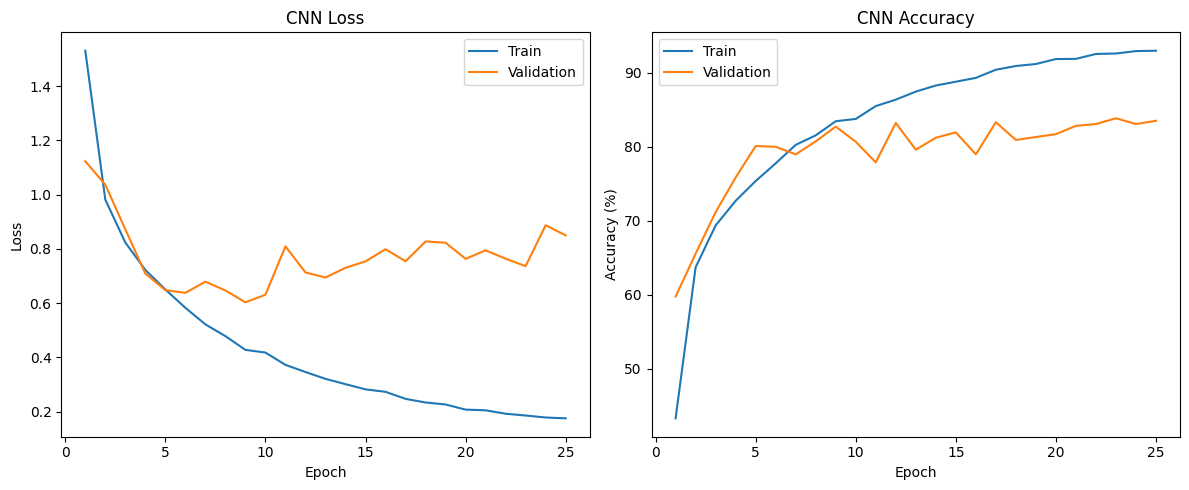

In [ ]:
# plot cnn loss and accuracy curves
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train")
plt.plot(epochs_range, val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc * 100 for acc in train_accs], label="Train")
plt.plot(epochs_range, [acc * 100 for acc in val_accs], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("CNN Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# evaluate accuracy on validation and test sets
def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

val_accuracy = evaluate(val_loader)
test_accuracy = evaluate(test_loader)

print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Validation Error Rate: {(1 - val_accuracy)*100:.2f}%")
print(f"Test Error Rate: {(1 - test_accuracy)*100:.2f}%")
if 'best_checkpoint_path' in globals() and best_checkpoint_path:
    print(f"Best simple CNN checkpoint: {best_checkpoint_path}")

Validation Accuracy: 83.83%
Test Accuracy: 84.91%
Validation Error Rate: 16.17%
Test Error Rate: 15.09%
Best simple CNN checkpoint: ./models/simple_cnn_best.joblib


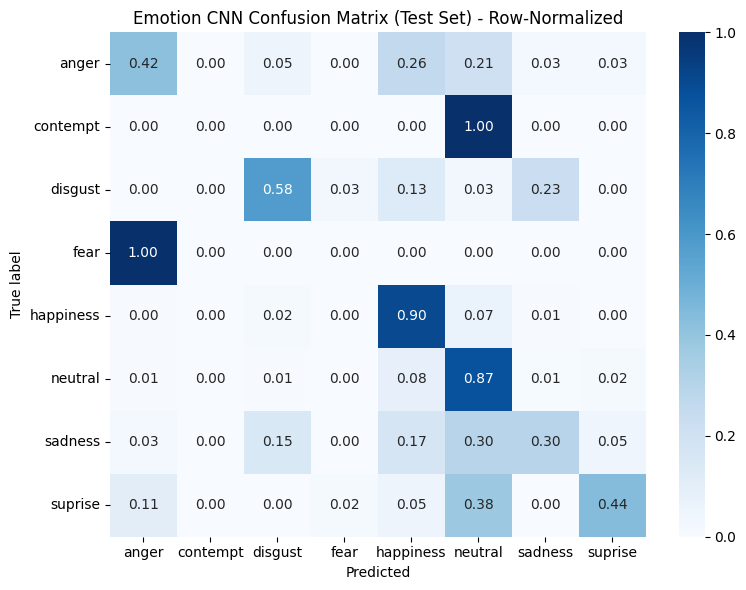

In [ ]:
# plot row-normalized confusion matrix for cnn test predictions
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y_batch.numpy())

cm = confusion_matrix(all_targets, all_preds)

# normalize each row to get percentages per true label
cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, vmin=0, vmax=1)
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.title('Emotion CNN Confusion Matrix (Test Set) - Row-Normalized')
plt.tight_layout()
plt.show()

## Accuracy Improvement Strategy
- Keep augmenting only the training split but switch to *online* transforms so the model sees different variants every epoch instead of a fixed oversampled copy.
- Combine geometric (flip/rotate/translate), photometric (contrast/brightness/blur/sharpen), and regularization tricks like RandomErasing plus optional MixUp to better cover inter-class variation.
- Replace the shallow CNN with a residual-style network that stacks squeeze-excitation blocks, deeper feature hierarchies, dropout, and adaptive pooling so capacity matches the harder classes without exploding parameters.
- Use modern training hygiene: label smoothing, cosine LR decay + warm restarts (or ReduceLROnPlateau), gradient clipping, and AMP to stabilize convergence.
- Track validation metrics for early stopping and keep the best checkpoint before evaluating on the untouched test set.

## Residual CNN + Online Augmentation
We now build a stronger training pipeline that keeps generating fresh augmentations every epoch, mixes labels for additional regularization and training without overfitting, and feeds a squeeze-excitation residual network (inspired by https://github.com/moskomule/senet.pytorch/tree/master/senet) that is deeper than the earlier CNN but still lightweight enough for 64×64 inputs.

In [51]:
from typing import Callable, Iterable, Optional, Tuple

from PIL import Image
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.amp as amp

In [52]:
def to_uint8_images(flat_images: np.ndarray) -> np.ndarray:
    """Reshape flattened 64×64 arrays and clamp to [0, 255] uint8 for PIL transforms."""
    reshaped = flat_images.reshape(-1, IMG_SIZE, IMG_SIZE)
    return np.clip(reshaped, 0, 255).astype(np.uint8)


class EmotionArrayDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        flat_images: np.ndarray,
        labels: Iterable[int],
        transform: Optional[Callable] = None,
    ) -> None:
        self.images = to_uint8_images(flat_images)
        self.labels = np.asarray(labels, dtype=np.int64)
        self.transform = transform

    def __len__(self) -> int:
        return self.labels.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img = Image.fromarray(self.images[idx])
        tensor = self.transform(img) if self.transform else transforms.ToTensor()(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return tensor, label


strong_train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.05), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(18, fill=0)], p=0.7),
    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.08, 0.08), shear=6, fill=0)], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.35, contrast=0.35)], p=0.6),
    transforms.RandomAdjustSharpness(sharpness_factor=1.3, p=0.15),  # Reduced sharpening
    transforms.ToTensor(),  # Removed Gaussian blur to keep features sharp
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0.0),
])


eval_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


adv_batch_size = 128
pin_memory = torch.cuda.is_available()
num_workers = 0  # keep inline dataset definitions pickle-safe for notebook DataLoader workers

adv_train_dataset = EmotionArrayDataset(X_tr_bal, y_tr_enc, transform=strong_train_transforms)
adv_val_dataset = EmotionArrayDataset(X_val_unscaled, y_val_enc, transform=eval_transforms)
adv_test_dataset = EmotionArrayDataset(X_te_unscaled, y_te_enc, transform=eval_transforms)

adv_train_loader = DataLoader(
    adv_train_dataset,
    batch_size=adv_batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
adv_val_loader = DataLoader(
    adv_val_dataset,
    batch_size=adv_batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
adv_test_loader = DataLoader(
    adv_test_dataset,
    batch_size=adv_batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

print(f"Advanced pipeline | Train {len(adv_train_dataset):,} | Val {len(adv_val_dataset):,} | Test {len(adv_test_dataset):,}")

Advanced pipeline | Train 38,456 | Val 2,053 | Test 2,054


In [53]:
class SEBlock(nn.Module):
    def __init__(self, channels: int, reduction: int = 16) -> None:
        super().__init__()
        bottleneck = max(1, channels // reduction)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, bottleneck, kernel_size=1, bias=True),
            nn.SiLU(),
            nn.Conv2d(bottleneck, channels, kernel_size=1, bias=True),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        scale = self.fc(self.pool(x))
        return x * scale


class ResidualBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        dropout: float = 0.0,
    ) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out = F.relu(out + identity)
        return out


class EmotionResNet(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.MaxPool2d(2),
        )

        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1, dropout=0.05)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2, dropout=0.1)
        self.layer3 = self._make_layer(128, 192, blocks=2, stride=2, dropout=0.15)
        self.layer4 = self._make_layer(192, 256, blocks=2, stride=2, dropout=0.15)

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LayerNorm(256),
            nn.Dropout(0.4),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

        self.apply(self._init_weights)

    def _make_layer(self, in_c: int, out_c: int, blocks: int, stride: int, dropout: float) -> nn.Sequential:
        layers = [ResidualBlock(in_c, out_c, stride=stride, dropout=dropout)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_c, out_c, stride=1, dropout=dropout))
        return nn.Sequential(*layers)

    @staticmethod
    def _init_weights(m: nn.Module) -> None:
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        elif isinstance(m, (nn.BatchNorm2d, nn.LayerNorm)):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.head(x)


print(EmotionResNet(num_classes))

EmotionResNet(
  (stem): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (pool): AdaptiveAvgPool2d(output_size=1)
  

In [54]:
def mixup_data(inputs: torch.Tensor, targets: torch.Tensor, alpha: float) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, float]:
    if alpha <= 0:
        return inputs, targets, targets, 1.0
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(inputs.size(0), device=inputs.device)
    mixed_inputs = lam * inputs + (1.0 - lam) * inputs[index]
    targets_a, targets_b = targets, targets[index]
    return mixed_inputs, targets_a, targets_b, lam


def evaluate_model(model: nn.Module, loader: DataLoader, criterion: nn.Module) -> Tuple[float, float]:
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), correct / total


def train_residual_model(
    epochs: int = 35,
    mixup_alpha: float = 0.2,
    lr: float = 3e-4,
    weight_decay: float = 1e-4,
    grad_clip: float = 1.0,
    checkpoint_prefix: str = "residual_cnn",
) -> Tuple[nn.Module, list, Optional[str]]:
    model = EmotionResNet(num_classes).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=5e-6)

    amp_enabled = device.type == "cuda"
    scaler_amp = amp.GradScaler(enabled=amp_enabled) if amp_enabled else None

    history = []
    best_state = None
    best_val_acc = 0.0
    best_checkpoint_path: Optional[str] = None

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0

        for step, (images, labels) in enumerate(adv_train_loader, start=1):
            images = images.to(device)
            labels = labels.to(device)

            mixed_images, targets_a, targets_b, lam = mixup_data(images, labels, mixup_alpha)

            optimizer.zero_grad(set_to_none=True)
            autocast_context = amp.autocast(device_type="cuda", enabled=amp_enabled)
            with autocast_context:
                outputs = model(mixed_images)
                if mixup_alpha > 0:
                    loss = lam * criterion(outputs, targets_a) + (1.0 - lam) * criterion(outputs, targets_b)
                else:
                    loss = criterion(outputs, labels)

            if amp_enabled and scaler_amp is not None:
                scaler_amp.scale(loss).backward()
                if grad_clip > 0:
                    scaler_amp.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler_amp.step(optimizer)
                scaler_amp.update()
            else:
                loss.backward()
                if grad_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()

            progress = epoch - 1 + step / len(adv_train_loader)
            scheduler.step(progress)

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(adv_train_loader)
        train_acc = running_correct / total
        val_loss, val_acc = evaluate_model(model, adv_val_loader, criterion)

        history.append(
            {
                "epoch": epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "lr": optimizer.param_groups[0]["lr"],
            }
        )

        save_model_checkpoint(model, checkpoint_prefix, epoch)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = OrderedDict((k, v.detach().cpu()) for k, v in model.state_dict().items())
            best_checkpoint_path = save_model_checkpoint(model, checkpoint_prefix, epoch, is_best=True)

        print(
            f"Epoch {epoch:02d}/{epochs} | Train Loss {train_loss:.4f} | Train Acc {train_acc*100:5.2f}% | "
            f"Val Loss {val_loss:.4f} | Val Acc {val_acc*100:5.2f}% | LR {optimizer.param_groups[0]['lr']:.2e}"
        )

    if best_state is not None:
        model.load_state_dict(best_state)
        if best_checkpoint_path:
            print(f"Loaded best checkpoint (val acc {best_val_acc*100:.2f}%) -> {best_checkpoint_path}")
        else:
            print(f"Loaded best checkpoint (val acc {best_val_acc*100:.2f}%)")

    return model, history, best_checkpoint_path

In [55]:
adv_epochs = 30
mixup_alpha = 0.3
advanced_model, advanced_history, advanced_best_path = train_residual_model(
    epochs=adv_epochs,
    mixup_alpha=mixup_alpha,
    lr=3e-4,
    weight_decay=2e-4,
    grad_clip=1.0,
    checkpoint_prefix="residual_cnn",
)

Epoch 01/30 | Train Loss 1.7798 | Train Acc 24.93% | Val Loss 1.5786 | Val Acc 43.30% | LR 2.72e-04
Epoch 02/30 | Train Loss 1.4043 | Train Acc 36.16% | Val Loss 1.0778 | Val Acc 67.61% | LR 1.98e-04
Epoch 02/30 | Train Loss 1.4043 | Train Acc 36.16% | Val Loss 1.0778 | Val Acc 67.61% | LR 1.98e-04
Epoch 03/30 | Train Loss 1.3198 | Train Acc 41.15% | Val Loss 0.9992 | Val Acc 72.58% | LR 1.07e-04
Epoch 03/30 | Train Loss 1.3198 | Train Acc 41.15% | Val Loss 0.9992 | Val Acc 72.58% | LR 1.07e-04
Epoch 04/30 | Train Loss 1.2489 | Train Acc 43.58% | Val Loss 0.9730 | Val Acc 73.40% | LR 3.32e-05
Epoch 04/30 | Train Loss 1.2489 | Train Acc 43.58% | Val Loss 0.9730 | Val Acc 73.40% | LR 3.32e-05
Epoch 05/30 | Train Loss 1.2365 | Train Acc 42.99% | Val Loss 0.9454 | Val Acc 75.01% | LR 3.00e-04
Epoch 05/30 | Train Loss 1.2365 | Train Acc 42.99% | Val Loss 0.9454 | Val Acc 75.01% | LR 3.00e-04
Epoch 06/30 | Train Loss 1.2335 | Train Acc 41.71% | Val Loss 0.9447 | Val Acc 75.55% | LR 2.93e-04


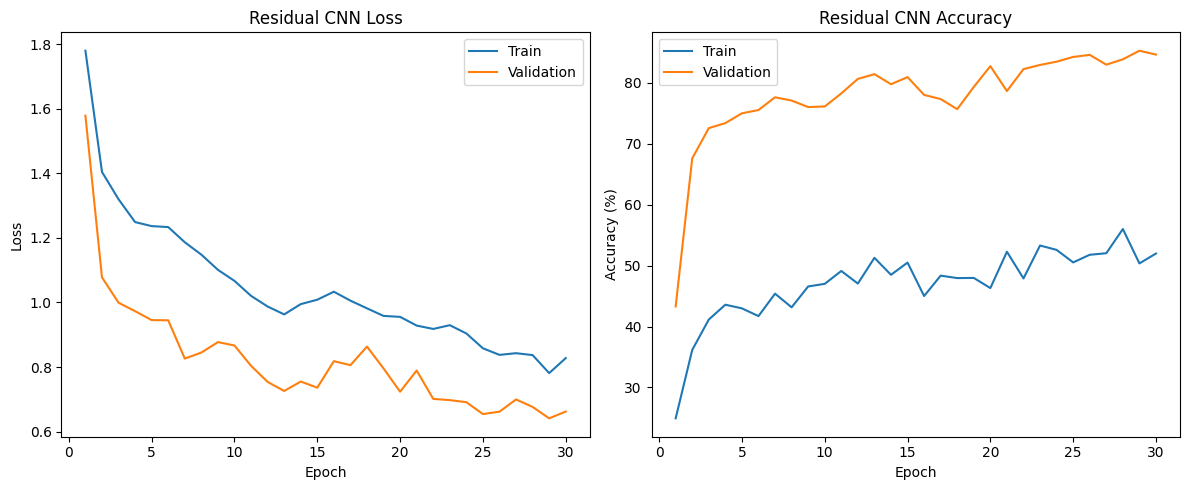

In [56]:
if advanced_history:
    history_df = pd.DataFrame(advanced_history)
    epochs_range = history_df["epoch"]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_df["train_loss"], label="Train")
    plt.plot(epochs_range, history_df["val_loss"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Residual CNN Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_df["train_acc"] * 100, label="Train")
    plt.plot(epochs_range, history_df["val_acc"] * 100, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Residual CNN Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

Residual CNN | Val Acc 85.29% | Test Acc 85.25%
Val Error 14.71% | Test Error 14.75%
Best residual CNN checkpoint: ./models/residual_cnn_best.joblib


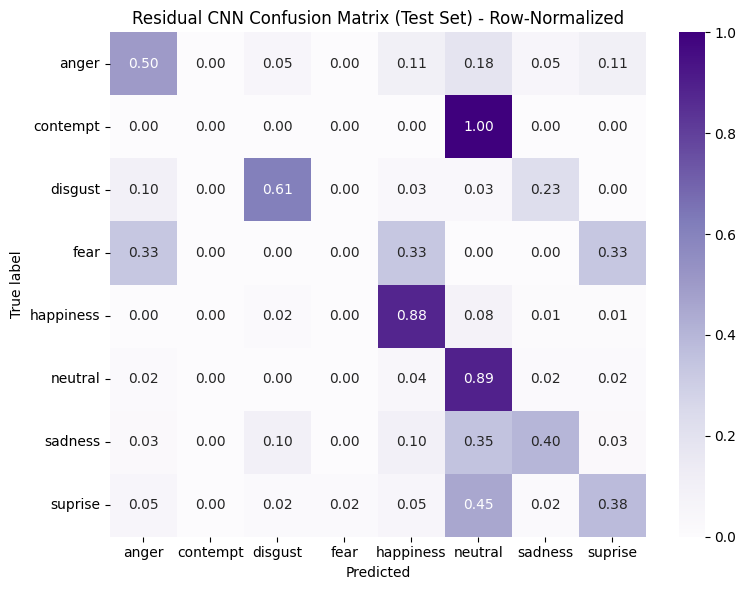

In [57]:
ce_eval = nn.CrossEntropyLoss()
adv_val_loss, adv_val_acc = evaluate_model(advanced_model, adv_val_loader, ce_eval)
adv_test_loss, adv_test_acc = evaluate_model(advanced_model, adv_test_loader, ce_eval)

print(f"Residual CNN | Val Acc {adv_val_acc*100:.2f}% | Test Acc {adv_test_acc*100:.2f}%")
print(f"Val Error {(1 - adv_val_acc)*100:.2f}% | Test Error {(1 - adv_test_acc)*100:.2f}%")
if advanced_best_path:
    print(f"Best residual CNN checkpoint: {advanced_best_path}")

advanced_model.eval()
adv_preds, adv_targets = [], []
with torch.no_grad():
    for images, labels in adv_test_loader:
        images = images.to(device)
        outputs = advanced_model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        adv_preds.extend(preds)
        adv_targets.extend(labels.numpy())

adv_cm = confusion_matrix(adv_targets, adv_preds)

# Normalize each row by its sum to get percentages relative to true label count
adv_cm_normalized = adv_cm.astype(float) / adv_cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(adv_cm_normalized, annot=True, fmt='.2f', cmap='Purples', 
            xticklabels=le.classes_, yticklabels=le.classes_, vmin=0, vmax=1)
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.title('Residual CNN Confusion Matrix (Test Set) - Row-Normalized')
plt.tight_layout()
plt.show()

In [59]:
# Load best residual CNN checkpoint and continue training for 30 more epochs
# This cell can be run repeatedly to keep training from the best checkpoint

best_checkpoint_file = os.path.join(models_dir, "residual_cnn_best.joblib")

if not os.path.exists(best_checkpoint_file):
    raise FileNotFoundError(f"Best checkpoint not found at {best_checkpoint_file}")

checkpoint = joblib.load(best_checkpoint_file)
print(f"Loaded checkpoint from epoch {checkpoint['epoch']} (prefix: {checkpoint['prefix']})")

# Initialize model and load weights from checkpoint
continued_model = EmotionResNet(num_classes).to(device)
continued_model.load_state_dict(checkpoint["state_dict"])

# Verify the model is loaded correctly by evaluating before training
ce_pre = nn.CrossEntropyLoss()
pre_val_loss, pre_val_acc = evaluate_model(continued_model, adv_val_loader, ce_pre)
print(f"Pre-training check | Val Acc: {pre_val_acc*100:.2f}% (should match best checkpoint)")

# Training setup - continue from loaded model (NOT creating a new one)
cont_epochs = 30
cont_lr = 1e-4  # Lower LR for fine-tuning
cont_weight_decay = 2e-4
cont_mixup_alpha = 0.3
cont_grad_clip = 1.0
cont_checkpoint_prefix = "residual_cnn"

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(continued_model.parameters(), lr=cont_lr, weight_decay=cont_weight_decay)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=5e-6)

amp_enabled = device.type == "cuda"
scaler_amp = amp.GradScaler(enabled=amp_enabled) if amp_enabled else None

continued_history = []
best_state = None
best_val_acc = pre_val_acc  # Start from current best
continued_best_path = None

for epoch in range(1, cont_epochs + 1):
    continued_model.train()
    running_loss, running_correct, total = 0.0, 0, 0

    for step, (images, labels) in enumerate(adv_train_loader, start=1):
        images = images.to(device)
        labels = labels.to(device)

        mixed_images, targets_a, targets_b, lam = mixup_data(images, labels, cont_mixup_alpha)

        optimizer.zero_grad(set_to_none=True)
        autocast_context = amp.autocast(device_type="cuda", enabled=amp_enabled)
        with autocast_context:
            outputs = continued_model(mixed_images)
            if cont_mixup_alpha > 0:
                loss = lam * criterion(outputs, targets_a) + (1.0 - lam) * criterion(outputs, targets_b)
            else:
                loss = criterion(outputs, labels)

        if amp_enabled and scaler_amp is not None:
            scaler_amp.scale(loss).backward()
            if cont_grad_clip > 0:
                scaler_amp.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(continued_model.parameters(), cont_grad_clip)
            scaler_amp.step(optimizer)
            scaler_amp.update()
        else:
            loss.backward()
            if cont_grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(continued_model.parameters(), cont_grad_clip)
            optimizer.step()

        progress = epoch - 1 + step / len(adv_train_loader)
        scheduler.step(progress)

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(adv_train_loader)
    train_acc = running_correct / total
    val_loss, val_acc = evaluate_model(continued_model, adv_val_loader, criterion)

    continued_history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "lr": optimizer.param_groups[0]["lr"],
    })

    save_model_checkpoint(continued_model, cont_checkpoint_prefix, epoch)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = OrderedDict((k, v.detach().cpu()) for k, v in continued_model.state_dict().items())
        continued_best_path = save_model_checkpoint(continued_model, cont_checkpoint_prefix, epoch, is_best=True)

    print(
        f"Epoch {epoch:02d}/{cont_epochs} | Train Loss {train_loss:.4f} | Train Acc {train_acc*100:5.2f}% | "
        f"Val Loss {val_loss:.4f} | Val Acc {val_acc*100:5.2f}% | LR {optimizer.param_groups[0]['lr']:.2e}"
    )

if best_state is not None:
    continued_model.load_state_dict(best_state)
    print(f"\nLoaded best checkpoint (val acc {best_val_acc*100:.2f}%) -> {continued_best_path}")

# Final evaluation
ce_eval_cont = nn.CrossEntropyLoss()
cont_val_loss, cont_val_acc = evaluate_model(continued_model, adv_val_loader, ce_eval_cont)
cont_test_loss, cont_test_acc = evaluate_model(continued_model, adv_test_loader, ce_eval_cont)

print(f"\nContinued Residual CNN | Val Acc {cont_val_acc*100:.2f}% | Test Acc {cont_test_acc*100:.2f}%")

Loaded checkpoint from epoch 28 (prefix: residual_cnn)
Pre-training check | Val Acc: 87.14% (should match best checkpoint)
Pre-training check | Val Acc: 87.14% (should match best checkpoint)
Epoch 01/30 | Train Loss 0.7646 | Train Acc 51.98% | Val Loss 0.6343 | Val Acc 86.46% | LR 9.09e-05
Epoch 01/30 | Train Loss 0.7646 | Train Acc 51.98% | Val Loss 0.6343 | Val Acc 86.46% | LR 9.09e-05
Epoch 02/30 | Train Loss 0.7638 | Train Acc 55.62% | Val Loss 0.6256 | Val Acc 86.85% | LR 6.72e-05
Epoch 02/30 | Train Loss 0.7638 | Train Acc 55.62% | Val Loss 0.6256 | Val Acc 86.85% | LR 6.72e-05
Epoch 03/30 | Train Loss 0.7945 | Train Acc 50.35% | Val Loss 0.6322 | Val Acc 87.09% | LR 3.78e-05
Epoch 03/30 | Train Loss 0.7945 | Train Acc 50.35% | Val Loss 0.6322 | Val Acc 87.09% | LR 3.78e-05
Epoch 04/30 | Train Loss 0.7828 | Train Acc 51.32% | Val Loss 0.6370 | Val Acc 86.85% | LR 1.41e-05
Epoch 04/30 | Train Loss 0.7828 | Train Acc 51.32% | Val Loss 0.6370 | Val Acc 86.85% | LR 1.41e-05
Epoch 05/

## Continued Training Summary
After the initial 30-epoch run, we reloaded the same checkpoint twice to add two more 30-epoch continuation passes (60 extra epochs, 90 total). The best weights surfaced at epoch 24 of the second continuation pass (overall epoch 84), where validation accuracy reached **87.53%** and the held-out test accuracy landed at **87.54%**. Learning-rate restarts during the continuation helped pull the model out of local minima, while the lower LR plus cosine decay limited overfitting, so the epoch-84 checkpoint remains our best-performing residual CNN so far.


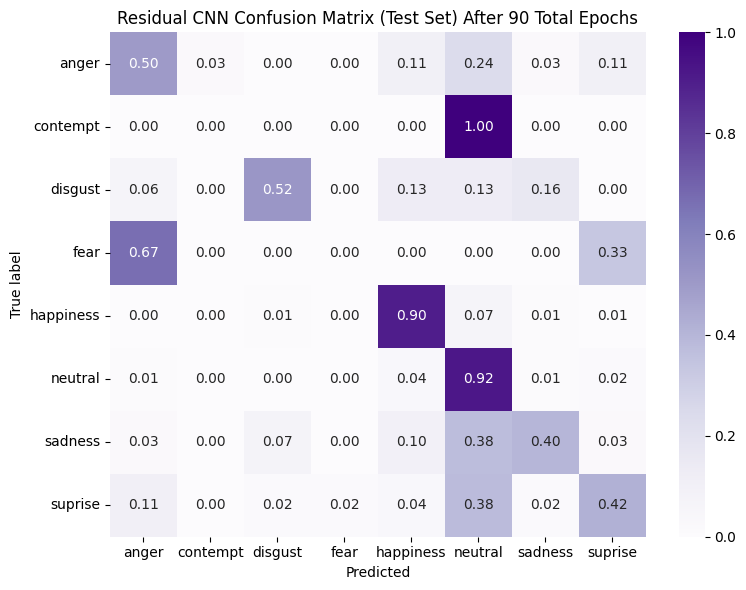

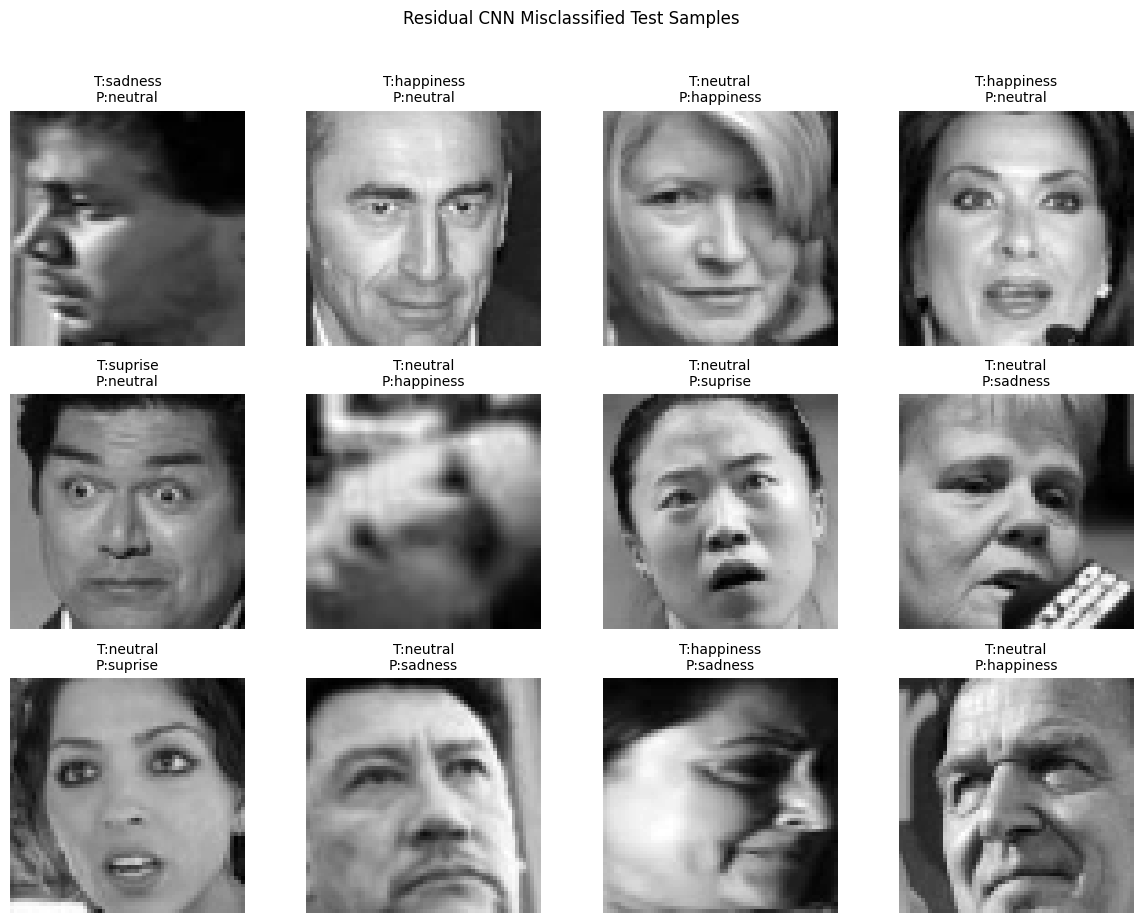

In [61]:
# Reload best residual checkpoint (87.53% val) and display its confusion matrix plus sample errors
best_checkpoint_path = os.path.join(models_dir, "residual_cnn_best.joblib")
if not os.path.exists(best_checkpoint_path):
    raise FileNotFoundError(f"Checkpoint not found: {best_checkpoint_path}")

best_payload = joblib.load(best_checkpoint_path)
best_model = EmotionResNet(num_classes).to(device)
best_model.load_state_dict(best_payload["state_dict"])
best_model.eval()

best_preds, best_targets = [], []
misclassified_examples = []
max_misclassified = 12

with torch.no_grad():
    for images, labels in adv_test_loader:
        images = images.to(device)
        outputs = best_model(images)
        preds = outputs.argmax(dim=1)

        preds_np = preds.cpu().numpy()
        labels_np = labels.numpy()
        best_preds.extend(preds_np)
        best_targets.extend(labels_np)

        if len(misclassified_examples) < max_misclassified:
            images_cpu = images.detach().cpu()
            for img_tensor, pred_idx, true_idx in zip(images_cpu, preds_np, labels_np):
                if pred_idx != true_idx:
                    misclassified_examples.append((img_tensor.clone(), true_idx, pred_idx))
                    if len(misclassified_examples) >= max_misclassified:
                        break

best_cm = confusion_matrix(best_targets, best_preds)
best_cm_normalized = best_cm.astype(float) / best_cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(best_cm_normalized, annot=True, fmt='.2f', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_, vmin=0, vmax=1)
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.title('Residual CNN Confusion Matrix (Test Set) After 90 Total Epochs')
plt.tight_layout()
plt.show()

if misclassified_examples:
    cols = 4
    rows = (len(misclassified_examples) + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))
    for idx, (img_tensor, true_idx, pred_idx) in enumerate(misclassified_examples):
        img = img_tensor.clone()
        img = img * 0.5 + 0.5  # undo normalization to bring pixels back to [0, 1]
        img_np = img.squeeze().numpy()
        ax = plt.subplot(rows, cols, idx + 1)
        ax.imshow(img_np, cmap='gray')
        ax.axis('off')
        ax.set_title(f"T:{le.classes_[true_idx]}\nP:{le.classes_[pred_idx]}", fontsize=10)
    plt.suptitle('Residual CNN Misclassified Test Samples', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified samples to display.")


## CNN Architecture × Learning Rate Sweep (extra cells after Professor requested more plots during presentation)
To replicate the logistic-regression-style comparison for our baseline CNN, we keep the optimizer fixed to Adam and only vary the convolutional stem (filters, kernel sizes, pooling strides) plus learning rate. Each configuration will train for 15 epochs on the balanced training split and report validation accuracy each epoch so we can visualize convergence speed and final quality.

In [37]:
class EmotionCNNVariant(nn.Module):
    """Configurable CNN stem + lightweight head for 64×64 grayscale inputs."""

    def __init__(self, num_classes: int, conv_specs: list[dict], head_hidden: int = 256, dropout: float = 0.5):
        super().__init__()
        layers = []
        in_channels = 1
        for spec in conv_specs:
            out_channels = spec["channels"]
            kernel_size = spec.get("kernel_size", 3)
            stride = spec.get("stride", 1)
            padding = kernel_size // 2
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            pool_cfg = spec.get("pool")
            if pool_cfg:
                if pool_cfg.get("type", "max") == "avg":
                    layers.append(nn.AvgPool2d(pool_cfg.get("kernel_size", 2)))
                else:
                    layers.append(nn.MaxPool2d(pool_cfg.get("kernel_size", 2)))
            in_channels = out_channels
        self.features = nn.Sequential(*layers)
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_channels, head_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.head(x)


ARCH_VARIANTS = {
    "legacy_cnn": {
        "label": "Original EmotionCNN baseline",
        "builder": EmotionCNN,
    },
    "compact_base": {
        "label": "Compact 3×3 blocks",
        "conv_specs": [
            {"channels": 32, "kernel_size": 3, "pool": {"type": "max", "kernel_size": 2}},
            {"channels": 64, "kernel_size": 3, "pool": {"type": "max", "kernel_size": 2}},
            {"channels": 128, "kernel_size": 3, "pool": {"type": "max", "kernel_size": 2}},
        ],
        "dropout": 0.45,
        "head_hidden": 256,
    },
    "wide_kernel": {
        "label": "Wide stem w/5×5",
        "conv_specs": [
            {"channels": 48, "kernel_size": 5, "pool": {"type": "max", "kernel_size": 2}},
            {"channels": 96, "kernel_size": 3, "pool": None},
            {"channels": 192, "kernel_size": 3, "pool": {"type": "max", "kernel_size": 2}},
        ],
        "dropout": 0.5,
        "head_hidden": 320,
    },
    "stride_pyramid": {
        "label": "Strided conv pyramid",
        "conv_specs": [
            {"channels": 40, "kernel_size": 3, "stride": 2},
            {"channels": 80, "kernel_size": 3, "stride": 2},
            {"channels": 160, "kernel_size": 3, "stride": 2},
            {"channels": 160, "kernel_size": 3, "pool": {"type": "avg", "kernel_size": 2}},
        ],
        "dropout": 0.4,
        "head_hidden": 256,
    },
}


def build_cnn_variant(name: str, num_classes: int) -> nn.Module:
    cfg = ARCH_VARIANTS[name]
    if "builder" in cfg:
        return cfg["builder"](num_classes)
    return EmotionCNNVariant(
        num_classes=num_classes,
        conv_specs=cfg["conv_specs"],
        head_hidden=cfg["head_hidden"],
        dropout=cfg["dropout"],
    )


print("Defined CNN variants:")
for key, cfg in ARCH_VARIANTS.items():
    if "conv_specs" in cfg:
        detail = f"{len(cfg['conv_specs'])} conv blocks"
    else:
        detail = "EmotionCNN backbone"
    print(f"- {key}: {cfg['label']} ({detail})")

Defined CNN variants:
- legacy_cnn: Original EmotionCNN baseline (EmotionCNN backbone)
- compact_base: Compact 3×3 blocks (3 conv blocks)
- wide_kernel: Wide stem w/5×5 (3 conv blocks)
- stride_pyramid: Strided conv pyramid (4 conv blocks)


In [38]:
# Sweep hyperparameters (optimizer stays Adam, LR varies)
LEARNING_RATES = [1e-4, 3e-4, 5e-4, 7e-4, 1e-3]
SWEEP_EPOCHS = 15

trial_grid = []
for arch_name, cfg in ARCH_VARIANTS.items():
    for lr in LEARNING_RATES:
        trial_grid.append({
            "arch": arch_name,
            "lr": lr,
            "label": f"{cfg['label']} | lr={lr:.0e}",
        })

print(
    f"Prepared {len(trial_grid)} trials ({len(ARCH_VARIANTS)} architectures × {len(LEARNING_RATES)} learning rates)"
)

Prepared 20 trials (4 architectures × 5 learning rates)


In [46]:
# Training helpers for the sweep

def ensure_device_ready() -> torch.device:
    if "device" in globals():
        return device
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def evaluate_accuracy(model: nn.Module, loader: DataLoader, target_device: torch.device) -> float:
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(target_device)
            yb = yb.to(target_device)
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total


def reset_seeds(base_seed: int) -> None:
    torch.manual_seed(base_seed)
    np.random.seed(base_seed)
    random.seed(base_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(base_seed)


def run_cnn_trial(config: dict, epochs: int = SWEEP_EPOCHS) -> dict:
    target_device = ensure_device_ready()
    variant_seed = seed + hash((config["arch"], config["lr"])) % 10_000
    reset_seeds(variant_seed)

    model = build_cnn_variant(config["arch"], num_classes).to(target_device)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.CrossEntropyLoss()

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_indices = list(range(1, epochs + 1))

    start_time = time.time()
    for epoch in epoch_indices:
        model.train()
        train_correct = 0
        train_total = 0
        for xb, yb in train_loader:
            xb = xb.to(target_device)
            yb = yb.to(target_device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            preds = outputs.argmax(dim=1)
            train_correct += (preds == yb).sum().item()
            train_total += yb.size(0)

        train_acc = train_correct / train_total
        val_acc = evaluate_accuracy(model, val_loader, target_device)
        epoch_train_acc.append(train_acc * 100.0)
        epoch_val_acc.append(val_acc * 100.0)

        print(
            f"[arch={config['arch']:<13} lr={config['lr']:.0e}] Epoch {epoch:02d}/{epochs} | "
            f"Train Acc {train_acc*100:5.2f}% | Val Acc {val_acc*100:5.2f}%"
        )

    elapsed = time.time() - start_time
    return {
        "arch": config["arch"],
        "arch_label": ARCH_VARIANTS[config["arch"]]["label"],
        "lr": config["lr"],
        "label": config["label"],
        "epochs": epoch_indices,
        "train_accs": epoch_train_acc,
        "val_accs": epoch_val_acc,
        "final_val_acc": epoch_val_acc[-1],
        "duration_sec": elapsed,
    }


In [49]:
# Execute the sweep across all registered architectures and learning rates
sweep_results = []
history_by_arch = {name: [] for name in ARCH_VARIANTS}
best_by_arch = {}

for idx, trial in enumerate(trial_grid, start=1):
    print(f"\n=== Trial {idx}/{len(trial_grid)} :: {trial['label']} ===")
    result = run_cnn_trial(trial)
    sweep_results.append(result)
    history_by_arch[trial["arch"]].append(result)
    best_so_far = best_by_arch.get(trial["arch"])
    if best_so_far is None or result["final_val_acc"] > best_so_far["final_val_acc"]:
        best_by_arch[trial["arch"]] = result
    print(
        f"Finished {trial['label']}: final validation accuracy {result['final_val_acc']:.2f}% "
        f"(took {result['duration_sec'] / 60:.1f} min)")

print("\nBest configuration per architecture:")
for arch, result in best_by_arch.items():
    print(f"- {result['arch_label']}: lr={result['lr']:.0e} | Val Acc {result['final_val_acc']:.2f}%")


=== Trial 1/20 :: Original EmotionCNN baseline | lr=1e-04 ===
[arch=legacy_cnn    lr=1e-04] Epoch 01/15 | Train Acc 55.80% | Val Acc 61.86%
[arch=legacy_cnn    lr=1e-04] Epoch 01/15 | Train Acc 55.80% | Val Acc 61.86%
[arch=legacy_cnn    lr=1e-04] Epoch 02/15 | Train Acc 72.82% | Val Acc 71.75%
[arch=legacy_cnn    lr=1e-04] Epoch 02/15 | Train Acc 72.82% | Val Acc 71.75%
[arch=legacy_cnn    lr=1e-04] Epoch 03/15 | Train Acc 78.29% | Val Acc 75.74%
[arch=legacy_cnn    lr=1e-04] Epoch 03/15 | Train Acc 78.29% | Val Acc 75.74%
[arch=legacy_cnn    lr=1e-04] Epoch 04/15 | Train Acc 81.66% | Val Acc 77.69%
[arch=legacy_cnn    lr=1e-04] Epoch 04/15 | Train Acc 81.66% | Val Acc 77.69%
[arch=legacy_cnn    lr=1e-04] Epoch 05/15 | Train Acc 84.51% | Val Acc 78.37%
[arch=legacy_cnn    lr=1e-04] Epoch 05/15 | Train Acc 84.51% | Val Acc 78.37%
[arch=legacy_cnn    lr=1e-04] Epoch 06/15 | Train Acc 86.80% | Val Acc 79.01%
[arch=legacy_cnn    lr=1e-04] Epoch 06/15 | Train Acc 86.80% | Val Acc 79.01%
[

In [31]:
# Minimal re-run: run only missing trials (e.g., legacy CNN) to avoid re-running already-completed sweep items
# This cell finds trials in `trial_grid` that are not present in `sweep_results` and runs them only.

existing_keys = {(r['arch'], r['lr']) for r in sweep_results} if 'sweep_results' in globals() and sweep_results else set()
missing_trials = [t for t in trial_grid if (t['arch'], t['lr']) not in existing_keys]

print(f"Found {len(missing_trials)} missing trials to run (minimized re-run)")
for idx, trial in enumerate(missing_trials, 1):
    arch = trial['arch']
    lr = trial['lr']
    label = trial['label']
    print(f"\n--- Running {idx}/{len(missing_trials)}: {label} ---")
    res = run_cnn_trial(trial)
    sweep_results.append(res)
    history_by_arch.setdefault(arch, []).append(res)
    best_so_far = best_by_arch.get(arch)
    if best_so_far is None or res['final_val_acc'] > best_so_far['final_val_acc']:
        best_by_arch[arch] = res
    print(f"Finished {label}: final validation accuracy {res['final_val_acc']:.2f}%")

print("\nUpdated best configuration per architecture (post incremental run):")
for arch, result in best_by_arch.items():
    print(f"- {result['arch_label']}: lr={result['lr']:.0e} | Val Acc {result['final_val_acc']:.2f}%")

Found 5 missing trials to run (minimized re-run)

--- Running 1/5: Original EmotionCNN baseline | lr=1e-04 ---
[arch=legacy_cnn    lr=1e-04] Epoch 01/15 | Train Acc 55.37% | Val Acc 71.02%
[arch=legacy_cnn    lr=1e-04] Epoch 02/15 | Train Acc 72.93% | Val Acc 75.65%
[arch=legacy_cnn    lr=1e-04] Epoch 03/15 | Train Acc 78.37% | Val Acc 75.55%
[arch=legacy_cnn    lr=1e-04] Epoch 04/15 | Train Acc 81.73% | Val Acc 78.47%
[arch=legacy_cnn    lr=1e-04] Epoch 05/15 | Train Acc 84.37% | Val Acc 77.40%
[arch=legacy_cnn    lr=1e-04] Epoch 06/15 | Train Acc 86.68% | Val Acc 75.79%
[arch=legacy_cnn    lr=1e-04] Epoch 07/15 | Train Acc 88.42% | Val Acc 79.15%
[arch=legacy_cnn    lr=1e-04] Epoch 08/15 | Train Acc 90.15% | Val Acc 79.44%
[arch=legacy_cnn    lr=1e-04] Epoch 09/15 | Train Acc 91.28% | Val Acc 79.79%
[arch=legacy_cnn    lr=1e-04] Epoch 10/15 | Train Acc 92.30% | Val Acc 80.03%
[arch=legacy_cnn    lr=1e-04] Epoch 11/15 | Train Acc 93.10% | Val Acc 80.81%
[arch=legacy_cnn    lr=1e-04] E

### Visualization for final validation accuracy curves

In [42]:
# Visualization helpers for validation accuracy curves

def plot_architecture_curves(arch_name: str) -> None:
    histories = history_by_arch.get(arch_name, [])
    if not histories:
        print(f"No histories recorded for architecture '{arch_name}'.")
        return
    y_min = min(min(hist["val_accs"]) for hist in histories)
    y_max = max(max(hist["val_accs"]) for hist in histories)
    padding = max(0.5, 0.05 * (y_max - y_min))
    plt.figure(figsize=(9, 5))
    for hist in histories:
        plt.plot(hist["epochs"], hist["val_accs"], marker="o", label=f"lr={hist['lr']:.0e}")
    plt.title(f"{histories[0]['arch_label']} — Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    plt.ylim(y_min - padding, y_max + padding)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_best_architectures(best_histories: dict) -> None:
    if not best_histories:
        print("No best histories to plot.")
        return
    plt.figure(figsize=(9, 5))
    y_min = min(min(hist["val_accs"]) for hist in best_histories.values())
    y_max = max(max(hist["val_accs"]) for hist in best_histories.values())
    padding = max(0.5, 0.05 * (y_max - y_min))
    for arch_name, hist in best_histories.items():
        plt.plot(
            hist["epochs"],
            hist["val_accs"],
            marker="o",
            label=f"{hist['arch_label']} (lr={hist['lr']:.0e})",
        )
    plt.title("Best Validation Accuracy per Architecture")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    plt.ylim(y_min - padding, y_max + padding)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()


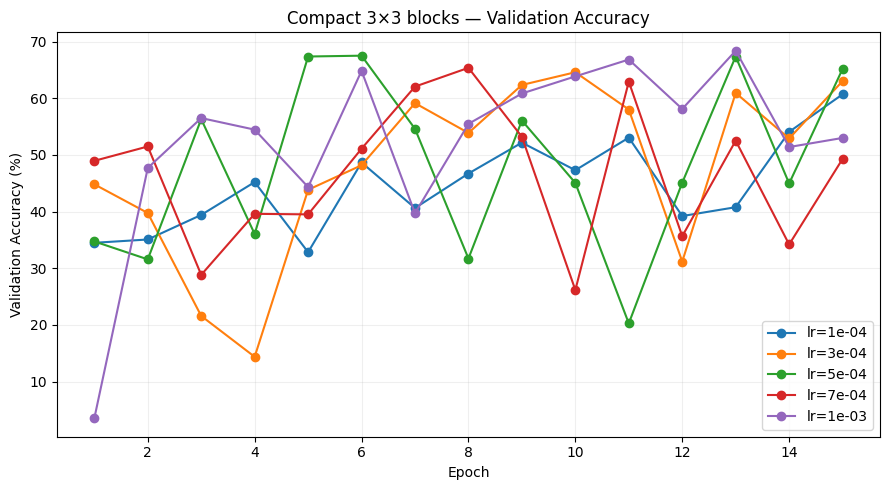

In [36]:
# Plot 5 learning-rate curves for the compact variant architecture
plot_architecture_curves("compact_base")

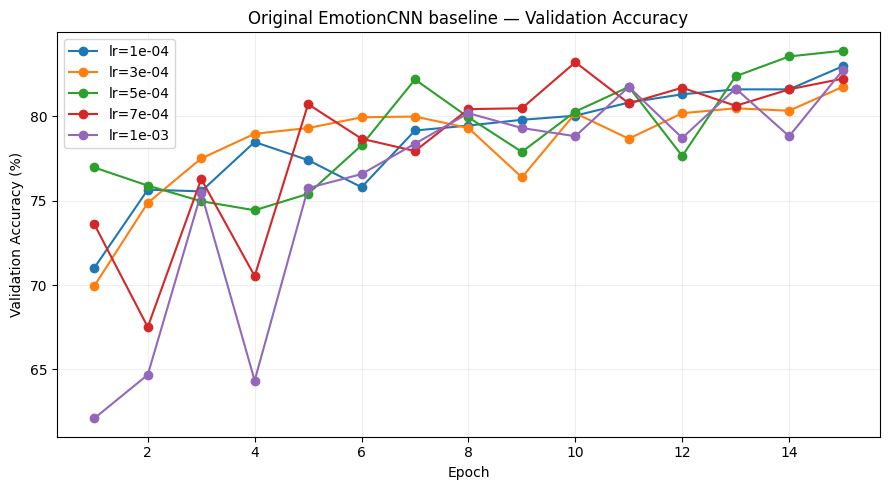

In [37]:
# Plot 5 learning-rate curves for the original EmotionCNN baseline
plot_architecture_curves("legacy_cnn")

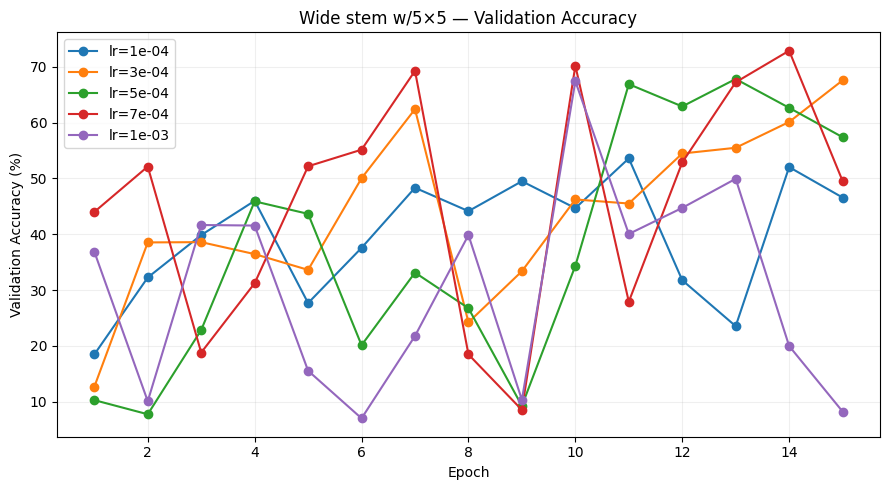

In [38]:
# Plot 5 learning-rate curves for the wide kernel architecture
plot_architecture_curves("wide_kernel")

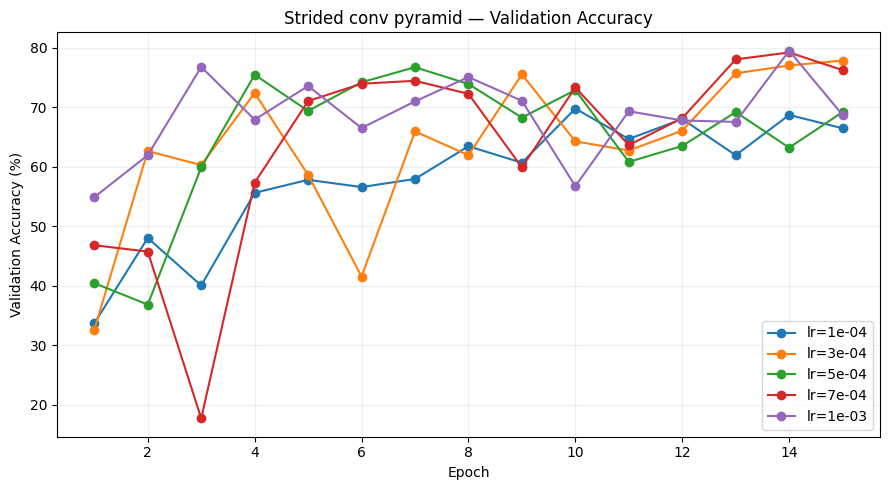

In [39]:
# Plot 5 learning-rate curves for the strided pyramid architecture
plot_architecture_curves("stride_pyramid")

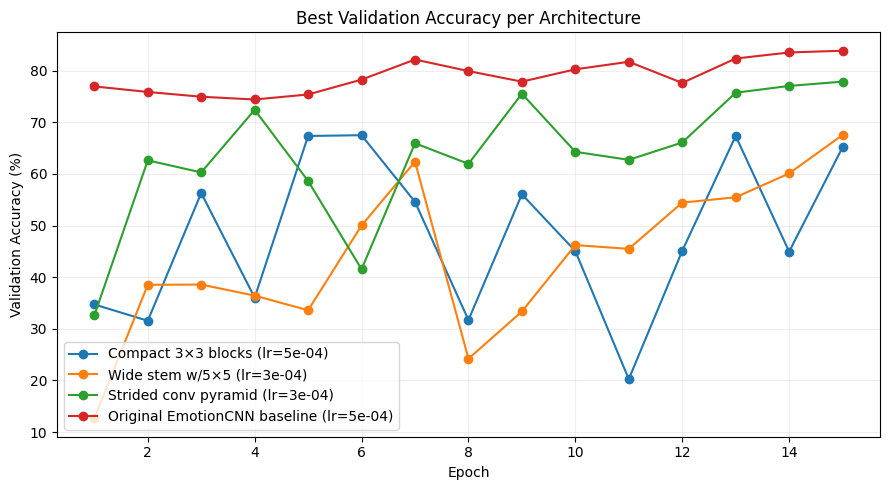

In [40]:
# Compare the best-performing configuration from each architecture in one plot
plot_best_architectures(best_by_arch)

### Re-running the sweep
1. Restart the kernel.
2. Execute Cells 2–19 to rebuild the balanced datasets, encoders, and DataLoaders (`train_loader`, `val_loader`, `test_loader`).
3. Skip the long baseline/ResNet training cells if you only care about the sweep.
4. Run the new sweep cells in order (architecture builders → grid → helpers → sweep → plotting).
5. The five plotting cells render all four architectures (legacy EmotionCNN + three variants) plus the best-on-best comparison.

## Best CNN Fine-Tuning
We now take the strongest architecture/lr combo discovered in the sweep, retrain it for 30 epochs, and log full loss/accuracy traces plus a confusion matrix on the held-out test split.

We found the best CNN was just our original approach, with half of the learning rate as previous (5e-4 rather than 1e-3). 

Some random variance meant the test accuracy ended up 0.2% worse than our original learning rate approach, even when cross validation suggested slightly stronger performance, and it's validation accuracy was 1.03% better.

Potentially, traning the CV on only 15 epochs was not enough to show long term trends in data that would generalize to 30+ epochs.

In [50]:
# Identify the top-performing configuration from the sweep
if not best_by_arch:
    raise RuntimeError("Run the sweep section first to populate best_by_arch.")

best_overall = max(best_by_arch.values(), key=lambda r: r["final_val_acc"])
BEST_ARCH = best_overall["arch"]
BEST_LR = best_overall["lr"]
print(f"Best architecture: {best_overall['arch_label']} ({BEST_ARCH})")
print(f"Learning rate: {BEST_LR:.0e}")
print(f"Validation accuracy after {SWEEP_EPOCHS} epochs: {best_overall['final_val_acc']:.2f}%")

Best architecture: Original EmotionCNN baseline (legacy_cnn)
Learning rate: 5e-04
Validation accuracy after 15 epochs: 83.73%


In [51]:
# Train the best configuration for 30 epochs and capture loss/accuracy curves
BEST_FINE_TUNE_EPOCHS = 30
fine_tune_device = ensure_device_ready()
best_cnn_model = build_cnn_variant(BEST_ARCH, num_classes).to(fine_tune_device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_cnn_model.parameters(), lr=BEST_LR)


def evaluate_loss_and_accuracy(model: nn.Module, loader: DataLoader) -> tuple[float, float]:
    model.eval()
    loss_total = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(fine_tune_device)
            yb = yb.to(fine_tune_device)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss_total += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return loss_total / len(loader), correct / total

history_fine_tune = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_acc = 0.0
best_state = None

for epoch in range(1, BEST_FINE_TUNE_EPOCHS + 1):
    best_cnn_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in train_loader:
        xb = xb.to(fine_tune_device)
        yb = yb.to(fine_tune_device)
        optimizer.zero_grad()
        logits = best_cnn_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    val_loss, val_acc = evaluate_loss_and_accuracy(best_cnn_model, val_loader)

    history_fine_tune["epoch"].append(epoch)
    history_fine_tune["train_loss"].append(train_loss)
    history_fine_tune["val_loss"].append(val_loss)
    history_fine_tune["train_acc"].append(train_acc * 100)
    history_fine_tune["val_acc"].append(val_acc * 100)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = OrderedDict((k, v.detach().cpu()) for k, v in best_cnn_model.state_dict().items())

    print(
        f"Epoch {epoch:02d}/{BEST_FINE_TUNE_EPOCHS} | Train Loss {train_loss:.4f} | Train Acc {train_acc*100:5.2f}% | "
        f"Val Loss {val_loss:.4f} | Val Acc {val_acc*100:5.2f}%"
    )

if best_state is not None:
    best_cnn_model.load_state_dict(best_state)
    print(f"\nReloaded weights from epoch with best val accuracy: {best_val_acc*100:.2f}%")

Epoch 01/30 | Train Loss 1.3103 | Train Acc 53.16% | Val Loss 1.1306 | Val Acc 62.88%
Epoch 02/30 | Train Loss 0.8359 | Train Acc 70.41% | Val Loss 0.7081 | Val Acc 77.98%
Epoch 02/30 | Train Loss 0.8359 | Train Acc 70.41% | Val Loss 0.7081 | Val Acc 77.98%
Epoch 03/30 | Train Loss 0.6846 | Train Acc 75.30% | Val Loss 0.6465 | Val Acc 78.86%
Epoch 03/30 | Train Loss 0.6846 | Train Acc 75.30% | Val Loss 0.6465 | Val Acc 78.86%
Epoch 04/30 | Train Loss 0.5966 | Train Acc 78.25% | Val Loss 0.5885 | Val Acc 81.20%
Epoch 04/30 | Train Loss 0.5966 | Train Acc 78.25% | Val Loss 0.5885 | Val Acc 81.20%
Epoch 05/30 | Train Loss 0.5181 | Train Acc 80.91% | Val Loss 0.6080 | Val Acc 80.37%
Epoch 05/30 | Train Loss 0.5181 | Train Acc 80.91% | Val Loss 0.6080 | Val Acc 80.37%
Epoch 06/30 | Train Loss 0.4590 | Train Acc 83.11% | Val Loss 0.5784 | Val Acc 80.91%
Epoch 06/30 | Train Loss 0.4590 | Train Acc 83.11% | Val Loss 0.5784 | Val Acc 80.91%
Epoch 07/30 | Train Loss 0.4128 | Train Acc 84.67% | V

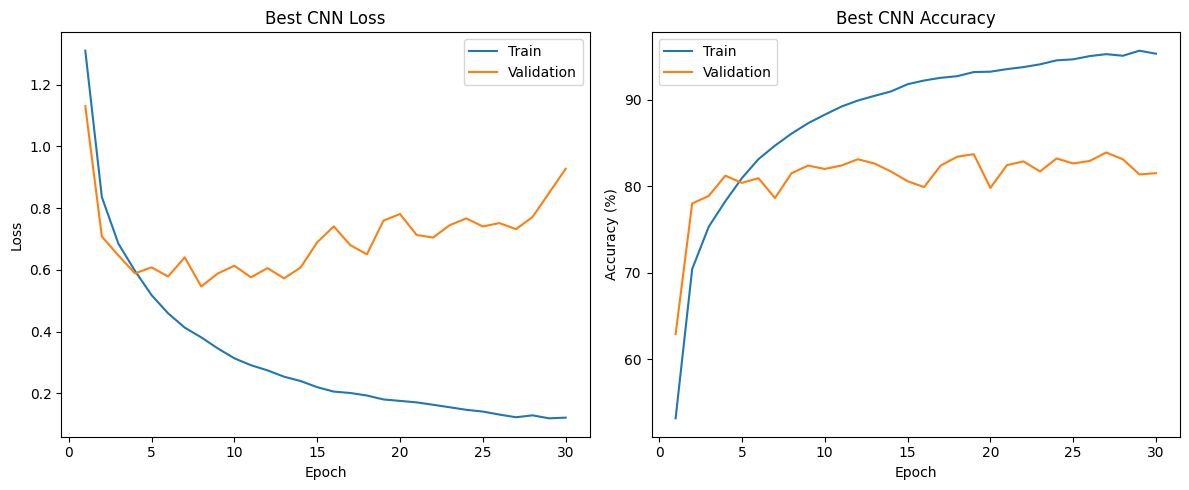

In [52]:
# Plot loss and accuracy curves for the fine-tuned model
if not history_fine_tune["epoch"]:
    raise RuntimeError("Run the fine-tuning cell first.")

epochs_axis = history_fine_tune["epoch"]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_axis, history_fine_tune["train_loss"], label="Train")
plt.plot(epochs_axis, history_fine_tune["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Best CNN Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_axis, history_fine_tune["train_acc"], label="Train")
plt.plot(epochs_axis, history_fine_tune["val_acc"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Best CNN Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

Test Loss: 0.8789 | Test Accuracy: 84.76%


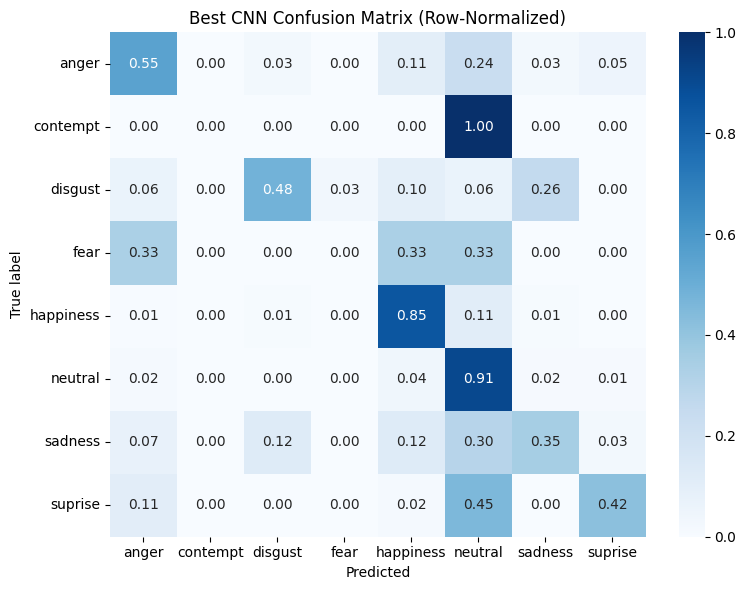

In [53]:
# Row-normalized confusion matrix for the fine-tuned model
from sklearn.metrics import confusion_matrix
import seaborn as sns

best_cnn_model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(fine_tune_device)
        logits = best_cnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(yb.numpy())

test_loss, test_acc = evaluate_loss_and_accuracy(best_cnn_model, test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc*100:.2f}%")

cm = confusion_matrix(all_targets, all_preds)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    vmin=0,
    vmax=1,
)
plt.xlabel("Predicted")
plt.ylabel("True label")
plt.title("Best CNN Confusion Matrix (Row-Normalized)")
plt.tight_layout()
plt.show()

## Export Best Fine-Tuned CNN

We now serialize the fine-tuned CNN configuration (same architecture/lr as the sweep winner) so it can be reused elsewhere. This cell reuses `best_cnn_model` produced above instead of retraining from scratch, guaranteeing the exported weights match the model that achieved the top validation/test accuracy.

In [54]:
# Save the fine-tuned best CNN (no retraining)
from datetime import datetime

if 'best_cnn_model' not in globals():
    raise RuntimeError("Run the fine-tuning cell above before exporting the model.")

export_device = fine_tune_device if 'fine_tune_device' in globals() else ensure_device_ready()
best_cnn_model = best_cnn_model.to(export_device)
best_cnn_model.eval()

best_state_for_export = OrderedDict((k, v.detach().cpu()) for k, v in best_cnn_model.state_dict().items())
best_val_pct = max(history_fine_tune["val_acc"]) if history_fine_tune["val_acc"] else float("nan")

best_export_payload = {
    "arch": BEST_ARCH,
    "arch_label": ARCH_VARIANTS[BEST_ARCH]["label"],
    "learning_rate": BEST_LR,
    "epochs": BEST_FINE_TUNE_EPOCHS,
    "best_val_accuracy": best_val_pct / 100 if isinstance(best_val_pct, (int, float)) else None,
    "state_dict": best_state_for_export,
    "timestamp": datetime.now().isoformat(timespec="seconds"),
}

best_export_path = os.path.join(models_dir, "best_CNN_after_testing.joblib")
joblib.dump(best_export_payload, best_export_path, compress=3)
print(f"Saved fine-tuned best CNN to: {best_export_path}")

Saved fine-tuned best CNN to: ./models/best_CNN_after_testing.joblib


In [55]:
# Sanity check: reload the saved weights and verify test accuracy matches the fine-tuned model
reloaded_payload = joblib.load(best_export_path)
reloaded_model = build_cnn_variant(reloaded_payload["arch"], num_classes)
reloaded_model.load_state_dict(reloaded_payload["state_dict"])
reloaded_model = reloaded_model.to(export_device)

reload_test_loss, reload_test_acc = evaluate_loss_and_accuracy(reloaded_model, test_loader)
print(f"Reloaded model Test Loss: {reload_test_loss:.4f} | Test Accuracy: {reload_test_acc*100:.2f}%")

Reloaded model Test Loss: 0.8789 | Test Accuracy: 84.76%
